<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/claudiamarcelacaro/Maestria_IA/blob/main/Disenio_software_inteligente/Proyecto_Deep_Learning_Claudia_Marcela_Caro_Cortes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab" title="Abrir y ejecutar en Google Colaboratory"/></a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/claudiamarcelacaro/Maestria_IA/blob/main/Disenio_software_inteligente/Proyecto_Deep_Learning_Claudia_Marcela_Caro_Cortes.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Abrir en Kaggle" title="Abrir y ejecutar en Kaggle"/></a>
  </td>
</table>

# Proyecto Diseño de Software Inteligente

**Name:** Claudia Marcela Caro Cortés <br>
**E-mail:** claudia.caro01@usa.edu.co <br>
[Github](https://github.com/claudiamarcelacaro).

**Conjunto de datos seleccionado:** *IBM HR Analytics Employee Attrition & Performance*

In [1209]:
!pip install -U imbalanced-learn
!pip install -U scikit-learn==1.2.0
!pip install PyQt5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1210]:
#import sys
#from PyQt5.QtWidgets import *
#import os
import tensorflow as tf
import keras
#os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
#os.environ['TF_KERAS'] = '1'
#os.environ["NVIDIA GeForce RTX 3060 Laptop GPU"] = "0"
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = '1'

In [1211]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd
import numpy as np
import pylab as pl
from zipfile import ZipFile
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #validar los datos imbalanceados
from sklearn.decomposition import PCA # (análisis para componentes principales) fusiona las características para la exploración de datos, metodo no supervisado
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from pylab import rcParams

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter #ayuda a contar clases

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Attrition"]

%matplotlib inline

In [1212]:
from keras import initializers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Convolution1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [1213]:
#!pip install pydot
#!pip install graphviz
#!conda install -c anaconda pydot=1.2.3
#!conda install -c anaconda pyparsing=2.2.0
#!conda install GraphViz

import errno
import pydot
from tensorflow.keras.utils import plot_model

## Utilidades

In [1214]:
def load_employee_data():
    tarball_path = Path("datasets/IBM_HR_Employee.zip")
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://raw.githubusercontent.com/claudiamarcelacaro/Maestria_IA/main/Disenio_software_inteligente/ibm-hr-analytics-attrition-dataset/IBM_HR_Employee.zip"
    urllib.request.urlretrieve(url, tarball_path)

    with ZipFile(tarball_path, 'r') as housing_tarball:
        housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/WA_Fn-UseC_-HR-Employee-Attrition.csv"))

employee = load_employee_data()

In [1215]:
def table_df(columna,X): 
    feature = X.groupby(columna).agg({'Attrition':['size', 'sum', 'mean']})
    feature.columns = [' '.join(col).strip() for col in feature.columns.values]
    feature = feature.reset_index()
    feature['Attrition mean'] = feature['Attrition mean']*100
    feature.columns = [columna, f"Total {X[columna].name}", '# Deserción Laboral(Attrition)', 
                       '% de Deserción Laboral(Attrition) en el grupo relevante'] 
    feature['% de Deserción Laboral en la Compañia'] = (feature['# Deserción Laboral(Attrition)'] / 237)*100
        
    return feature

In [1216]:
#crea la gráfica de barras horizontal
def graph_df(columna, X, y = 'bar', z = 0):
    feature = X.groupby(columna).agg({'Attrition':['size', 'sum', 'mean']})
    feature.columns = [' '.join(col).strip() for col in feature.columns.values]
    feature = feature.reset_index()
    feature['Attrition mean'] = feature['Attrition mean']*100
    feature.columns = [columna, 'Total Empleados', 'Attrition Number', 
                       '% de Deserción Laboral en el grupo relevante'] 
    
    fig0, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    feature.set_index(feature[columna], drop=True, inplace=True)
    feature['Total Empleados'].plot(kind = y, stacked = True, ax = ax1, 
                                   colormap = 'winter', rot = z)
    feature['% de Deserción Laboral en el grupo relevante'].plot(use_index = False, 
                                                         kind = 'line', ax = ax2, colormap='Spectral')
    plt.title('Deserción Laboral comparado con' + " Grupo" + " " + columna)
    ax1.set_xlabel(columna)
    ax1.yaxis.label.set_color('blue')
    ax1.set_ylabel("Total Empleados")
    ax2.set_ylabel("% Attrition en el grupo relevante")
    ax2.yaxis.label.set_color('red')
    plt.tight_layout()
    plt.show()

In [1217]:
# código extra - código para guardar las figuras como PNG de alta resolución para el libro

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [1218]:
# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color.reshape(1,-1),
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def plot_labels(n_folds, n_classes, list_labels):
    ind = np.arange(n_folds)
    width = 0.15
    
    countings = []
    for labels in list_labels:
        labels = np.array(labels)
        countings.append([np.count_nonzero(labels == x) for x in range(n_classes)])
    
    class_bars = []
    for cls in range(n_classes):
        class_bars.append([l[cls] for l in countings])
    
    fig, ax = pl.subplots()
    i = 0
    for class_bar in class_bars:
        ax.bar(ind + width*i, class_bar, width, label='Clase '+str(i))
        i += 1
        
    ax.set_xticks(ind + 2*width / 3)
    ax.set_xticklabels(['Pliegue {}'.format(k) for k in range(n_folds)])
    pl.legend(loc="best")
    pl.title("Etiquetas")

Inicializa semilla aleatoria

In [1219]:
np.random.seed(40)

## Comprender los datos

In [1220]:
employee.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [1221]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

* Hay 1470 instancias del conjunto de datos, no posee valores nulos. Posee 34 atributos de los cuales 26 son numéricos y 8 son de texto. <br>

* La variable objetivo con la que se va a trabajar es: "Attrition"

**Validar si hay datos faltantes:**

In [1222]:
employee.isna().sum().sum()

0

No posee datos faltantes.

**Validar si hay valores únicos en las características:**

In [1223]:
employee.nunique().sort_values()

Over18                         1
StandardHours                  1
EmployeeCount                  1
Gender                         2
Attrition                      2
PerformanceRating              2
OverTime                       2
MaritalStatus                  3
Department                     3
BusinessTravel                 3
StockOptionLevel               4
EnvironmentSatisfaction        4
JobInvolvement                 4
JobSatisfaction                4
RelationshipSatisfaction       4
WorkLifeBalance                4
Education                      5
JobLevel                       5
EducationField                 6
TrainingTimesLastYear          7
JobRole                        9
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate

**Para agregar al preprocesamiento:**<br>
Eliminar las característica que no aportan al analisis:<br>
'Over18', 'StandardHours', 'EmployeeCount', 'EmployeeNumber'

* El dataset está desbalanceado

In [1224]:
employee["Attrition"].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

In [1225]:
employee["Attrition"].name

'Attrition'

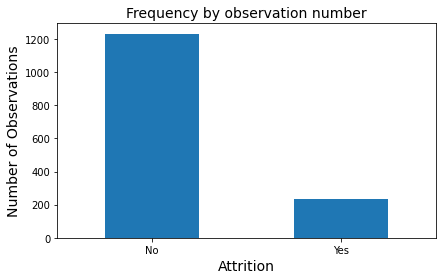

In [1226]:
count_attrion = pd.value_counts(employee["Attrition"], sort = True)
count_attrion.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.xlabel("Attrition") #deserción laboral
save_fig("attrition_unbalanced")  # extra code
plt.ylabel("Number of Observations");

In [1227]:
(1233 - 237) / 1233

0.8077858880778589

En el set de datos se observa muy pocos datos donde se registre la deserción laboral.

In [1228]:
normal_df = employee[employee.Attrition == 'Yes'] # guardar las observaciones de normal_df en un df separado
attrition_df = employee[employee.Attrition == 'No']  # hacer lo mismo con las deserciones laborales

* Análisis comparativo normalizado entre las variables del dataset y su relación con la deserción laboral

In [1229]:
df2 = employee.copy()

In [1230]:
#Reasignando valor
df2['Attrition'] = df2['Attrition'].apply(lambda x: 0 if x == 'No' else 1)

Análisis de la variable numérica Age:

In [1231]:
#Age
table_df(columna = 'Age', X = df2)
bins = [17, 21, 25, 35, 60]
group_names = ['(18-21)', '(22-25)', '(26-35)', '(36-60)']
df2['Age'] = pd.cut(employee['Age'], bins, labels = group_names)
table_df(columna = 'Age', X = df2)

Age  Total Age  # Deserción Laboral(Attrition)  \
0  (18-21)         41                              22   
1  (22-25)         82                              22   
2  (26-35)        606                             116   
3  (36-60)        741                              77   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          53.658537         
1                                          26.829268         
2                                          19.141914         
3                                          10.391363         

   % de Deserción Laboral en la Compañia  
0                               9.282700  
1                               9.282700  
2                              48.945148  
3                              32.489451

<Figure size 432x288 with 0 Axes>

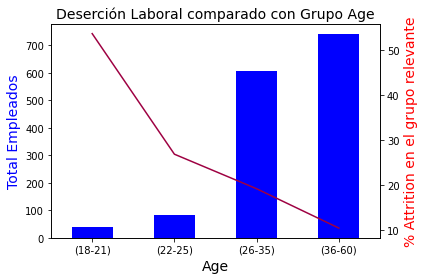

In [1232]:
# Deserción Laboral comparada con el grupo de Edades
save_fig("Attrition_Age_Percent")  # extra code
graph_df(columna = 'Age', X = df2)

El mayor porcentaje de deserción laboral se presenta en la población de 18-21 años con el 53.66%, la deserción disminuye con el paso de los años.

Análisis de la variable categórica BusinessTravel:

In [1233]:
#BusinessTravel
table_df(columna = 'BusinessTravel', X = df2)
table_df(columna = 'BusinessTravel', X = df2)

BusinessTravel  Total BusinessTravel  # Deserción Laboral(Attrition)  \
0         Non-Travel                   150                              12   
1  Travel_Frequently                   277                              69   
2      Travel_Rarely                  1043                             156   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                           8.000000         
1                                          24.909747         
2                                          14.956855         

   % de Deserción Laboral en la Compañia  
0                               5.063291  
1                              29.113924  
2                              65.822785

<Figure size 432x288 with 0 Axes>

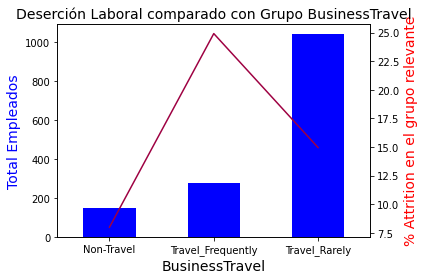

In [1234]:
# Deserción Laboral comparada con el grupo de viaje de negocios
save_fig("Attrition_BusinessTravel_Percent")  # extra code
graph_df(columna = 'BusinessTravel', X = df2)

La mayor deserción se da en el grupo de trabajadores Viajeros Frecuentes con el 24.90%

In [1235]:
#DailyRate
table_df(columna = 'DailyRate', X = df2)
bins = [1, 500, 1000, 1500]
group_names = ['(1-500)', '(501-1000)', '(1001-1500)']
df2['DailyRate'] = pd.cut(employee['DailyRate'], bins, labels = group_names)
table_df(columna = 'DailyRate', X = df2)

DailyRate  Total DailyRate  # Deserción Laboral(Attrition)  \
0      (1-500)              405                              78   
1   (501-1000)              542                              88   
2  (1001-1500)              523                              71   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          19.259259         
1                                          16.236162         
2                                          13.575526         

   % de Deserción Laboral en la Compañia  
0                              32.911392  
1                              37.130802  
2                              29.957806

<Figure size 432x288 with 0 Axes>

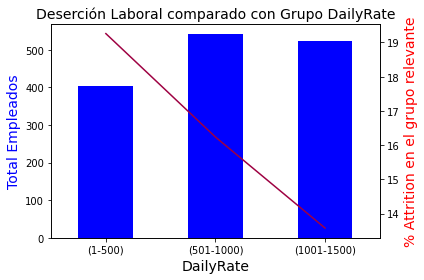

In [1236]:
# Deserción Laboral comparada con el grupo de tarifa diaria
save_fig("Attrition_DailyRate_Percent")  # extra code
graph_df(columna = 'DailyRate', X = df2)

La mayor deserción laboral se presenta en los trabajadores que menos ganan a diario, los que ganan entre 1-500 dólares poseen una deserción del 19.25%. La deserción disminuye entre mayor sea su tarifa diaria.

In [1237]:
#Department
table_df(columna = 'Department', X = df2)
table_df(columna = 'Department', X = df2)

Department  Total Department  # Deserción Laboral(Attrition)  \
0         Human Resources                63                              12   
1  Research & Development               961                             133   
2                   Sales               446                              92   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          19.047619         
1                                          13.839750         
2                                          20.627803         

   % de Deserción Laboral en la Compañia  
0                               5.063291  
1                              56.118143  
2                              38.818565

<Figure size 432x288 with 0 Axes>

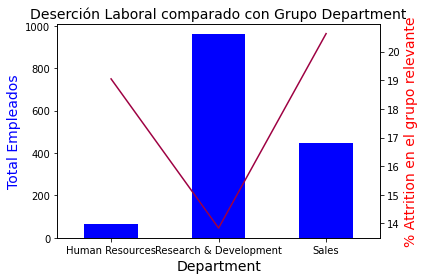

In [1238]:
# Deserción Laboral comparada con el grupo de departamentos
save_fig("Attrition_Department_Percent")  # extra code
graph_df(columna = 'Department', X = df2)

El departamento de Investigación y Desarrollo (Research & Development) es el que posee menor tasa de deserción del 13.84% y el de mayor deserción el depatamento de Ventas (Sales) con el 20.62%.

In [1239]:
#DistanceFromHome
table_df(columna = 'DistanceFromHome', X = df2)
bins = [1, 5, 10, 30]
group_names = ['(1-5)', '(6-10)', '(+10)']
df2['DistanceFromHome'] = pd.cut(employee['DistanceFromHome'], bins, labels = group_names)
table_df(columna = 'DistanceFromHome', X = df2)

DistanceFromHome  Total DistanceFromHome  # Deserción Laboral(Attrition)  \
0            (1-5)                     424                              61   
1           (6-10)                     394                              57   
2            (+10)                     444                              93   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          14.386792         
1                                          14.467005         
2                                          20.945946         

   % de Deserción Laboral en la Compañia  
0                              25.738397  
1                              24.050633  
2                              39.240506

<Figure size 432x288 with 0 Axes>

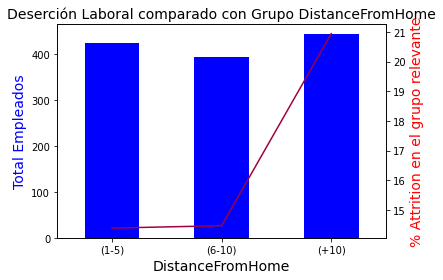

In [1240]:
# Deserción Laboral comparada con la distacia desde la casa
save_fig("Attrition_DistanceFromHome_Percent")  # extra code
graph_df(columna = 'DistanceFromHome', X = df2)

Poseen una deserción laboral más alta del 20.95% las personas que vinen a más de 10 millas del lugar de trabajo. La deserción aumenta con la distancia entre la casa y el trabajo.

In [1241]:
#Education
df2['Education'] = df2['Education'].map({1:'Below College', 2:'College', 3:'Bachelor', 4:'Master', 5:'Doctor'})
table_df(columna = 'Education', X = df2)

Education  Total Education  # Deserción Laboral(Attrition)  \
0       Bachelor              572                              99   
1  Below College              170                              31   
2        College              282                              44   
3         Doctor               48                               5   
4         Master              398                              58   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          17.307692         
1                                          18.235294         
2                                          15.602837         
3                                          10.416667         
4                                          14.572864         

   % de Deserción Laboral en la Compañia  
0                              41.772152  
1                              13.080169  
2                              18.565401  
3                               2.109705  
4                              24.472574

<Figure size 432x288 with 0 Axes>

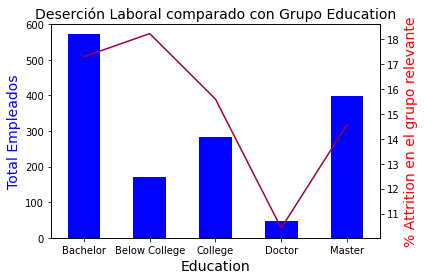

In [1242]:
# Deserción Laboral comparada con el grupo de educación
save_fig("Attrition_Education_Percent")  # extra code
graph_df(columna = 'Education', X = df2)

Los empleados que cursan niveles inferiores de escolaridad son los que tienen mayor Deserción Laboral con el Bachelor del 17.30% y Bellow College con el 18.23% de deserción laboral, entre ambos representan el 35.53% de la deserción de la empresa, siendo muy representativo.

In [1243]:
#EducationField
table_df(columna = 'EducationField', X = df2)
table_df(columna = 'EducationField', X = df2)

EducationField  Total EducationField  # Deserción Laboral(Attrition)  \
0   Human Resources                    27                               7   
1     Life Sciences                   606                              89   
2         Marketing                   159                              35   
3           Medical                   464                              63   
4             Other                    82                              11   
5  Technical Degree                   132                              32   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          25.925926         
1                                          14.686469         
2                                          22.012579         
3                                          13.577586         
4                                          13.414634         
5                                          24.242424         

   % de Deserción Laboral en la Compañia  
0                               2.953586  
1                              37.552743  
2                              14.767932  
3                              26.582278  
4                               4.641350  
5                              13.502110

<Figure size 432x288 with 0 Axes>

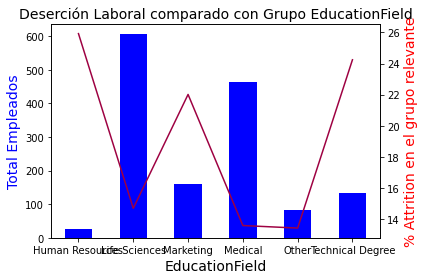

In [1244]:
# Deserción Laboral comparada con el grupo de campo educativo
save_fig("Attrition_EducationField_Percent")  # extra code
graph_df(columna = 'EducationField', X = df2)

El área de educación que posee mayor deserción laboral es el de Recursos Humanos con el 25.93% seguido de los que poseen títulos técnicos con el 24.24%.

In [1245]:
#EmployeeCount
df2['EmployeeCount'].unique()

array([1])

Esta característica no es representativa. Se eliminará más adelante de los datos a analizar.

In [1246]:
#EmployeeNumber
table_df(columna = 'EmployeeNumber', X = df2)
bins = [1, 500, 1000, 1500, 2068]
group_names = ['(1-500)', '(501-1000)', '(1001-1500)', '(1501-2068)']
df2['EmployeeNumber'] = pd.cut(employee['EmployeeNumber'], bins, labels = group_names)
table_df(columna = 'EmployeeNumber', X = df2)

EmployeeNumber  Total EmployeeNumber  # Deserción Laboral(Attrition)  \
0        (1-500)                   376                              56   
1     (501-1000)                   340                              58   
2    (1001-1500)                   348                              66   
3    (1501-2068)                   405                              56   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          14.893617         
1                                          17.058824         
2                                          18.965517         
3                                          13.827160         

   % de Deserción Laboral en la Compañia  
0                              23.628692  
1                              24.472574  
2                              27.848101  
3                              23.628692

<Figure size 432x288 with 0 Axes>

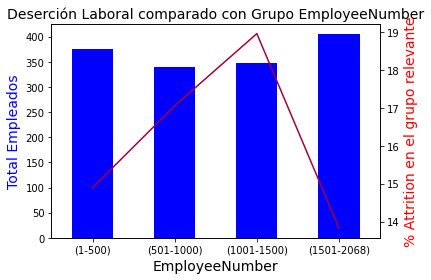

In [1247]:
# Deserción Laboral comparada con el grupo de número de empleados de la empresa
save_fig("Attrition_EmployeeNumber_Percent")  # extra code
graph_df(columna = 'EmployeeNumber', X = df2)

El número de empleados no es determinante en la deserción laboral de la empresa, ya que tiene un comportamiento uniforme en cualquier clasifiación. Se eliminará esta característica del conjunto de datos a analizar más adelante.

In [1248]:
#EnvironmentSatisfaction
df2['EnvironmentSatisfaction'] = df2['EnvironmentSatisfaction'].map({1:'Low', 2:'Medium', 3:'High', 4:'Very High'})
table_df(columna = 'EnvironmentSatisfaction', X = df2)

EnvironmentSatisfaction  Total EnvironmentSatisfaction  \
0                    High                            453   
1                     Low                            284   
2                  Medium                            287   
3               Very High                            446   

   # Deserción Laboral(Attrition)  \
0                              62   
1                              72   
2                              43   
3                              60   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          13.686534         
1                                          25.352113         
2                                          14.982578         
3                                          13.452915         

   % de Deserción Laboral en la Compañia  
0                              26.160338  
1                              30.379747  
2                              18.143460  
3                              25.316456

<Figure size 432x288 with 0 Axes>

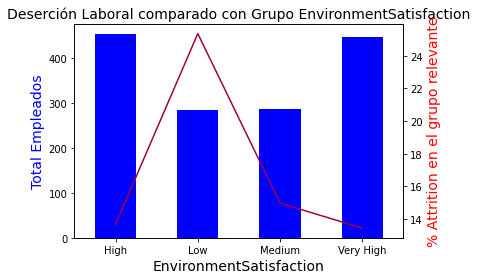

In [1249]:
# Deserción Laboral comparada con el grupo satisfación con el ambiente laboral
save_fig("Attrition_EnvironmentSatisfaction_Percent")  # extra code
graph_df(columna = 'EnvironmentSatisfaction', X = df2)

Con una satisfación con el ambiente laboral baja se obtiene el mayor porcentaje de deserción laboral, del 25,35 %

Análisis de la variable categórica binaria Gender:

In [1250]:
#Gender
table_df(columna = 'Gender', X = df2)
table_df(columna = 'Gender', X = df2)

Gender  Total Gender  # Deserción Laboral(Attrition)  \
0  Female           588                              87   
1    Male           882                             150   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          14.795918         
1                                          17.006803         

   % de Deserción Laboral en la Compañia  
0                              36.708861  
1                              63.291139

<Figure size 432x288 with 0 Axes>

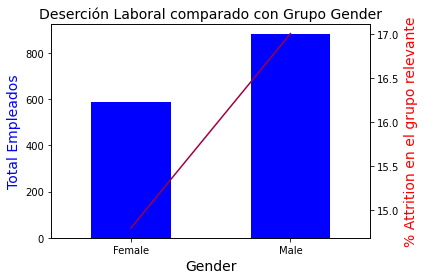

In [1251]:
# Deserción Laboral comparada con el género
save_fig("Attrition_Gender_Percent")  # extra code
graph_df(columna = 'Gender', X = df2)

Se tiene una mayor deserción laboral de los hombres respecto a las mujeres con el 17%.

In [1252]:
#HourlyRate
table_df(columna = 'EmployeeNumber', X = df2)
bins = [30, 50, 80, 100]
group_names = ['(30-50)', '(51-80)', '(81-100)']
df2['EmployeeNumber'] = pd.cut(employee['EmployeeNumber'], bins, labels = group_names)
table_df(columna = 'EmployeeNumber', X = df2)

EmployeeNumber  Total EmployeeNumber  # Deserción Laboral(Attrition)  \
0        (30-50)                    14                               5   
1        (51-80)                    25                               4   
2       (81-100)                    14                               1   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          35.714286         
1                                          16.000000         
2                                           7.142857         

   % de Deserción Laboral en la Compañia  
0                               2.109705  
1                               1.687764  
2                               0.421941

<Figure size 432x288 with 0 Axes>

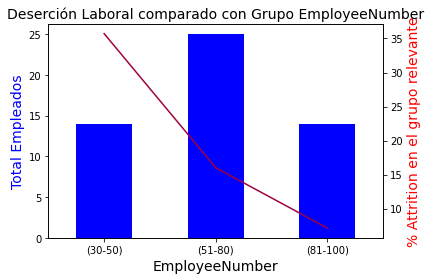

In [1253]:
# Deserción Laboral comparada con el grupode número de empleados
save_fig("Attrition_EmployeeNumber_Percent")  # extra code
graph_df(columna = 'EmployeeNumber', X = df2)

La característica EmployeeNumber no es relevante en el porcetaje de deserción laboral de la compañia. Se eliminará esta característica del conjunto de datos a analizar más adelante.

In [1254]:
#JobInvolvement
df2['JobInvolvement'] = df2['JobInvolvement'].map({1:'Low', 2:'Medium', 3:'High', 4:'Very High'})
table_df(columna = 'JobInvolvement', X = df2)

JobInvolvement  Total JobInvolvement  # Deserción Laboral(Attrition)  \
0           High                   868                             125   
1            Low                    83                              28   
2         Medium                   375                              71   
3      Very High                   144                              13   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          14.400922         
1                                          33.734940         
2                                          18.933333         
3                                           9.027778         

   % de Deserción Laboral en la Compañia  
0                              52.742616  
1                              11.814346  
2                              29.957806  
3                               5.485232

<Figure size 432x288 with 0 Axes>

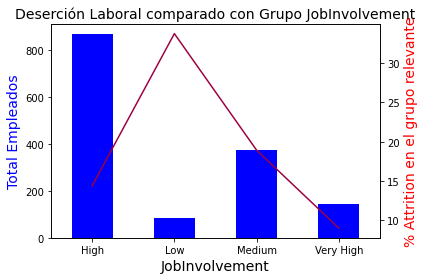

In [1255]:
# Deserción Laboral comparada con el grupo de participación en el trabajo
save_fig("Attrition_JobInvolvement_Percent")  # extra code
graph_df(columna = 'JobInvolvement', X = df2)

Dentro del grupo de JobInvolvement la característica con mayor relevancia en porcentaje de nivel de deserción laboral fue el nivel bajo con un 33.73%, sin embargo la cantidad de empleados no es representativo. La calificación Hight es la más representativa a nivel compañía con un 14.4% de deserción pero que representa el 52.74% de deserción a nivel empresa.

In [1256]:
#JobLevel
df2['JobLevel'] = df2['JobLevel'].map({1:'Level-1', 2:'Level-2', 3:'Level-3', 4:'Level-4', 5:'Level-5'})
table_df(columna = 'JobLevel', X = df2)

JobLevel  Total JobLevel  # Deserción Laboral(Attrition)  \
0  Level-1             543                             143   
1  Level-2             534                              52   
2  Level-3             218                              32   
3  Level-4             106                               5   
4  Level-5              69                               5   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          26.335175         
1                                           9.737828         
2                                          14.678899         
3                                           4.716981         
4                                           7.246377         

   % de Deserción Laboral en la Compañia  
0                              60.337553  
1                              21.940928  
2                              13.502110  
3                               2.109705  
4                               2.109705

<Figure size 432x288 with 0 Axes>

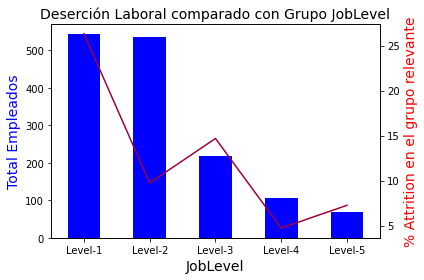

In [1257]:
# Deserción Laboral comparada con el grupo de nivel de trabajo
save_fig("Attrition_JobLevel_Percent")  # extra code
graph_df(columna = 'JobLevel', X = df2)

La deserción disminuye con el aumento del nivel de trabajo. Se tiene el mayor porcetaje de deserción en el Nivel-1 con 26.33%.

In [1258]:
#JobRole
table_df(columna = 'JobRole', X = df2)
table_df(columna = 'JobRole', X = df2)

JobRole  Total JobRole  # Deserción Laboral(Attrition)  \
0  Healthcare Representative            131                               9   
1            Human Resources             52                              12   
2      Laboratory Technician            259                              62   
3                    Manager            102                               5   
4     Manufacturing Director            145                              10   
5          Research Director             80                               2   
6         Research Scientist            292                              47   
7            Sales Executive            326                              57   
8       Sales Representative             83                              33   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                           6.870229         
1                                          23.076923         
2                                          23.938224         
3                                           4.901961         
4                                           6.896552         
5                                           2.500000         
6                                          16.095890         
7                                          17.484663         
8                                          39.759036         

   % de Deserción Laboral en la Compañia  
0                               3.797468  
1                               5.063291  
2                              26.160338  
3                               2.109705  
4                               4.219409  
5                               0.843882  
6                              19.831224  
7                              24.050633  
8                              13.924051

<Figure size 432x288 with 0 Axes>

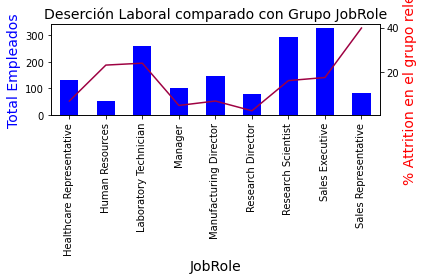

In [1259]:
# Deserción Laboral comparada con el grupo de nivel de trabajo
save_fig("Attrition_JobRole_Percent")  # extra code
graph_df(columna = 'JobRole', X = df2, z = 90)

Los Técnicos de Laboratorio poseen el mayor nivel de deserción a nivel de la compañia con el 26.16% seguido del Ejecutivo de Ventas con un 24.05%.

In [1260]:
#JobSatisfaction
df2['JobSatisfaction'] = df2['JobSatisfaction'].map({1:'Low', 2:'Medium', 3:'High', 4:'Very High'}) 
table_df(columna = 'JobSatisfaction', X = df2)

JobSatisfaction  Total JobSatisfaction  # Deserción Laboral(Attrition)  \
0            High                    442                              73   
1             Low                    289                              66   
2          Medium                    280                              46   
3       Very High                    459                              52   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          16.515837         
1                                          22.837370         
2                                          16.428571         
3                                          11.328976         

   % de Deserción Laboral en la Compañia  
0                              30.801688  
1                              27.848101  
2                              19.409283  
3                              21.940928

<Figure size 432x288 with 0 Axes>

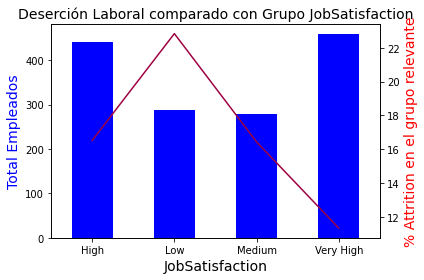

In [1261]:
# Deserción Laboral comparada con el grupo de satisfacción laboral
save_fig("Attrition_JobSatisfaction_Percent")  # extra code
graph_df(columna = 'JobSatisfaction', X = df2)

Es sorpresivo que el mayor porcentaje de Deserción Laboral se presente con un nivel alto (High) de satisfacción laboral con un 30.80% a nivel de toda la compañía. 

In [1262]:
#MaritalStatus
table_df(columna = 'MaritalStatus', X = df2)
table_df(columna = 'MaritalStatus', X = df2)

MaritalStatus  Total MaritalStatus  # Deserción Laboral(Attrition)  \
0      Divorced                  327                              33   
1       Married                  673                              84   
2        Single                  470                             120   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          10.091743         
1                                          12.481426         
2                                          25.531915         

   % de Deserción Laboral en la Compañia  
0                              13.924051  
1                              35.443038  
2                              50.632911

<Figure size 432x288 with 0 Axes>

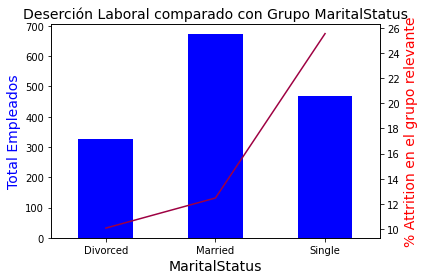

In [1263]:
# Deserción Laboral comparada con el grupo de estado civil
save_fig("Attrition_MaritalStatus_Percent")  # extra code
graph_df(columna = 'MaritalStatus', X = df2)

Los empleados Solteros son los que tienen mayor porcentaje de deserción laboral a nivel de la empresa con un 50.63%.

In [1264]:
#MonthlyIncome
table_df(columna = "MonthlyIncome", X = df2)
bins = [1000, 2000, 3000, 5000, 7500, 10000, 15000, 20000]
group_names = ['1000-2500', '2501-3000', '3501-5000', '5001-7500', '7501-10000', '10001-15000', '15001-20000']             
df2['MonthlyIncome'] = pd.cut(employee['MonthlyIncome'], bins, labels = group_names)
table_df(columna = 'MonthlyIncome', X = df2)

MonthlyIncome  Total MonthlyIncome  # Deserción Laboral(Attrition)  \
0     1000-2500                   33                              18   
1     2501-3000                  362                              95   
2     3501-5000                  354                              50   
3     5001-7500                  310                              30   
4    7501-10000                  130                              19   
5   10001-15000                  148                              20   
6   15001-20000                  133                               5   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          54.545455         
1                                          26.243094         
2                                          14.124294         
3                                           9.677419         
4                                          14.615385         
5                                          13.513514         
6                                           3.759398         

   % de Deserción Laboral en la Compañia  
0                               7.594937  
1                              40.084388  
2                              21.097046  
3                              12.658228  
4                               8.016878  
5                               8.438819  
6                               2.109705

<Figure size 432x288 with 0 Axes>

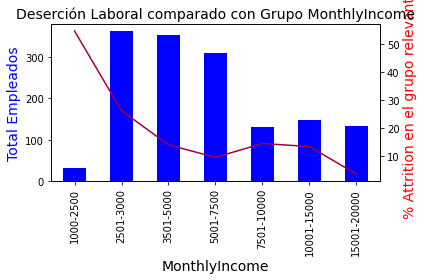

In [1265]:
# Deserción Laboral comparada con el grupo de sueldo mensual
save_fig("Attrition_MonthlyIncome_Percent")  # extra code
graph_df(columna = 'MonthlyIncome', X = df2, z = 90)

La mayor deserción laboral se da en los rangos salariales de 2501-3000 dólares con un 40% a nivel de toda la empresa.

In [1266]:
#MonthlyRate
table_df(columna = "MonthlyRate", X = df2)
bins = [2000, 5000, 10000, 15000, 20000, 27000]
group_names = ['2000-5000', '5001-10000', '10001-15000', '15001-20000', '20001-27000']             
df2['MonthlyRate'] = pd.cut(employee['MonthlyRate'], bins, labels = group_names)
table_df(columna = 'MonthlyRate', X = df2)

MonthlyRate  Total MonthlyRate  # Deserción Laboral(Attrition)  \
0    2000-5000                171                              30   
1   5001-10000                316                              42   
2  10001-15000                287                              53   
3  15001-20000                298                              44   
4  20001-27000                398                              68   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          17.543860         
1                                          13.291139         
2                                          18.466899         
3                                          14.765101         
4                                          17.085427         

   % de Deserción Laboral en la Compañia  
0                              12.658228  
1                              17.721519  
2                              22.362869  
3                              18.565401  
4                              28.691983

<Figure size 432x288 with 0 Axes>

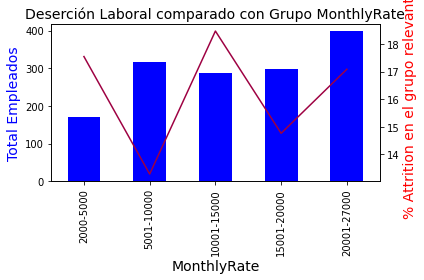

In [1267]:
# Deserción Laboral comparada con el grupo de la tasa mensual
save_fig("Attrition_MonthlyRate_Percent")  # extra code
graph_df(columna = 'MonthlyRate', X = df2, z = 90)

Se observa que el grupo con mayor deserción laboral es el de 20001-27000 con un 28.29% a nivel de la empresa.

In [1268]:
#NumCompaniesWorked
table_df(columna = 'NumCompaniesWorked', X = df2)
table_df(columna = 'NumCompaniesWorked', X = df2)

NumCompaniesWorked  Total NumCompaniesWorked  \
0                   0                       197   
1                   1                       521   
2                   2                       146   
3                   3                       159   
4                   4                       139   
5                   5                        63   
6                   6                        70   
7                   7                        74   
8                   8                        49   
9                   9                        52   

   # Deserción Laboral(Attrition)  \
0                              23   
1                              98   
2                              16   
3                              16   
4                              17   
5                              16   
6                              16   
7                              17   
8                               6   
9                              12   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          11.675127         
1                                          18.809981         
2                                          10.958904         
3                                          10.062893         
4                                          12.230216         
5                                          25.396825         
6                                          22.857143         
7                                          22.972973         
8                                          12.244898         
9                                          23.076923         

   % de Deserción Laboral en la Compañia  
0                               9.704641  
1                              41.350211  
2                               6.751055  
3                               6.751055  
4                               7.172996  
5                               6.751055  
6                               6.751055  
7                               7.172996  
8                               2.531646  
9                               5.063291

<Figure size 432x288 with 0 Axes>

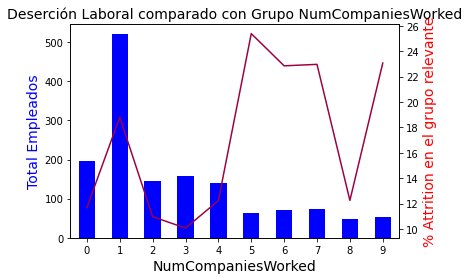

In [1269]:
# Deserción Laboral comparada con la cantidad de compañía en que ha trabajado
save_fig("Attrition_NumCompaniesWorked_Percent")  # extra code
graph_df(columna = 'NumCompaniesWorked', X = df2)

A nivel de la empresa, quienes tienen una sola experiencia anterior son los que tienen mayor nivel de deserción laboral con un 41.35% a nivel de la empresa.

In [1270]:
#Over18
df2['Over18'].unique()

array(['Y'], dtype=object)

Esta característica no es relevante. Se eliminará esta característica del conjunto de datos a analizar más adelante.

In [1271]:
#OverTime
table_df(columna = 'OverTime', X = df2)
table_df(columna = 'OverTime', X = df2)

OverTime  Total OverTime  # Deserción Laboral(Attrition)  \
0       No            1054                             110   
1      Yes             416                             127   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          10.436433         
1                                          30.528846         

   % de Deserción Laboral en la Compañia  
0                              46.413502  
1                              53.586498

<Figure size 432x288 with 0 Axes>

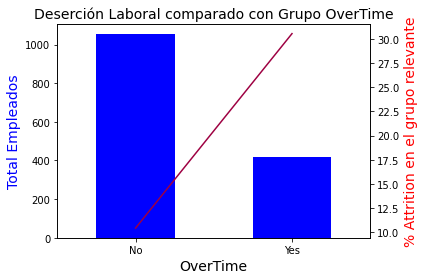

In [1272]:
# Deserción Laboral comparada con trabajo extra
save_fig("Attrition_OverTime_Percent")  # extra code
graph_df(columna = 'OverTime', X = df2)

Esta característica es muy representativa indicando que OverTime o tiempo extra de trabajo del horario laboral tiene un porcentaje alto de deserción laboral con el 53.58% a nivel de la empresa.

In [1273]:
#PercentSalaryHike
table_df(columna = "PercentSalaryHike", X = df2)
bins = [10, 12, 15, 18, 20, 25]
group_names = ['10-12', '13-15', '16-18', '18-20', '21-25']          
df2['PercentSalaryHike'] = pd.cut(employee['PercentSalaryHike'], bins, labels = group_names)
table_df(columna = 'PercentSalaryHike', X = df2)

PercentSalaryHike  Total PercentSalaryHike  # Deserción Laboral(Attrition)  \
0             10-12                      408                              74   
1             13-15                      511                              76   
2             16-18                      249                              41   
3             18-20                      131                              16   
4             21-25                      171                              30   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          18.137255         
1                                          14.872798         
2                                          16.465863         
3                                          12.213740         
4                                          17.543860         

   % de Deserción Laboral en la Compañia  
0                              31.223629  
1                              32.067511  
2                              17.299578  
3                               6.751055  
4                              12.658228

<Figure size 432x288 with 0 Axes>

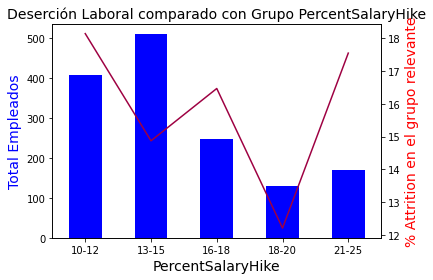

In [1274]:
# Deserción Laboral comparada con el grupo de porcentaje de aumento salarial
save_fig("Attrition_PercentSalaryHike_Percent")  # extra code
graph_df(columna = 'PercentSalaryHike', X = df2)

La mayor deserción laboral se da en los aumentos salariales más bajos, 32% a nivel de la compañía para los aumentos entre 13-15 dólares y del 31.22% a nivel de la compañia a los aumentos entre 10-12 dólares.

In [1275]:
#PerformanceRating
df2['PerformanceRating'] = df2['PerformanceRating'].map({1:'Low', 2:'Good', 3:'Excellent', 4:'Outstanding'}) 
table_df(columna = 'PerformanceRating', X = df2)

PerformanceRating  Total PerformanceRating  # Deserción Laboral(Attrition)  \
0         Excellent                     1244                             200   
1       Outstanding                      226                              37   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          16.077170         
1                                          16.371681         

   % de Deserción Laboral en la Compañia  
0                              84.388186  
1                              15.611814

<Figure size 432x288 with 0 Axes>

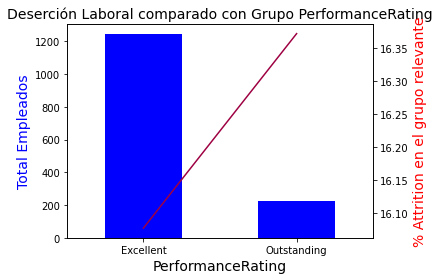

In [1276]:
# Deserción Laboral comparada con el grupo rendimiento
save_fig("Attrition_PerformanceRating_Percent")  # extra code
graph_df(columna = 'PerformanceRating', X = df2)

A nivel de la compañía las persona con un rendimiento Excelente son las que tienen mayor tasa de deserción laboral con un 84.38% a nivel de la empresa, lo cual por lacantidad de empleados en esa clasificación es muy representativa.

In [1277]:
#RelationshipSatisfaction
df2['RelationshipSatisfaction'] = df2['RelationshipSatisfaction'].map({1:'Low', 2:'Medium', 3:'High', 4:'Very High'})
table_df(columna = 'RelationshipSatisfaction', X = df2)

RelationshipSatisfaction  Total RelationshipSatisfaction  \
0                     High                             459   
1                      Low                             276   
2                   Medium                             303   
3                Very High                             432   

   # Deserción Laboral(Attrition)  \
0                              71   
1                              57   
2                              45   
3                              64   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          15.468410         
1                                          20.652174         
2                                          14.851485         
3                                          14.814815         

   % de Deserción Laboral en la Compañia  
0                              29.957806  
1                              24.050633  
2                              18.987342  
3                              27.004219

<Figure size 432x288 with 0 Axes>

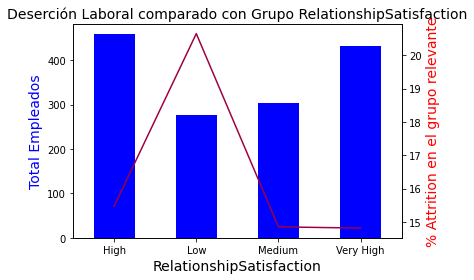

In [1278]:
# Deserción Laboral comparada con el grupo rendimiento
save_fig("Attrition_RelationshipSatisfaction_Percent")  # extra code
graph_df(columna = 'RelationshipSatisfaction', X = df2)

Es sorpresivo que a nivel de la empresa los empleados que indicaron un nivel de satisfacción Alto (High) sean los que tiene la mayor tasa de deserción laboral del 29.95% a nievl de la empresa.

In [1279]:
#StandardHours
df2['StandardHours'].unique()

array([80])

Esta característica no es relevante. Se eliminará esta característica del conjunto de datos a analizar más adelante.

In [1280]:
#StockOptionLevel
table_df(columna = 'StockOptionLevel', X = df2)
table_df(columna = 'StockOptionLevel', X = df2)

StockOptionLevel  Total StockOptionLevel  # Deserción Laboral(Attrition)  \
0                 0                     631                             154   
1                 1                     596                              56   
2                 2                     158                              12   
3                 3                      85                              15   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          24.405705         
1                                           9.395973         
2                                           7.594937         
3                                          17.647059         

   % de Deserción Laboral en la Compañia  
0                              64.978903  
1                              23.628692  
2                               5.063291  
3                               6.329114

<Figure size 432x288 with 0 Axes>

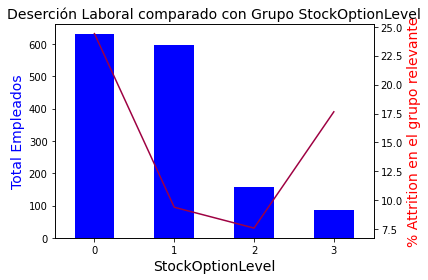

In [1281]:
# Deserción Laboral comparada con la cantidad de acciones
save_fig("Attrition_StockOptionLevel_Percent")  # extra code
graph_df(columna = 'StockOptionLevel', X = df2)

Los trabajadores sin acciones son los que teiene mayor nivel de deserción laboral con el 64.97% a nivel de la empresa.

In [1282]:
#TotalWorkingYears
table_df(columna = "TotalWorkingYears", X = df2)
bins = [0, 1, 5, 10, 15, 20, 40]
group_names = ['0-1', '2-5', '6-10', '11-15', '16-20', '20+']         
df2['TotalWorkingYears'] = pd.cut(employee['TotalWorkingYears'], bins, labels = group_names)
table_df(columna = 'TotalWorkingYears', X = df2)

TotalWorkingYears  Total TotalWorkingYears  # Deserción Laboral(Attrition)  \
0               0-1                       81                              40   
1               2-5                      224                              46   
2              6-10                      607                              91   
3             11-15                      191                              24   
4             16-20                      149                              15   
5               20+                      207                              16   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          49.382716         
1                                          20.535714         
2                                          14.991763         
3                                          12.565445         
4                                          10.067114         
5                                           7.729469         

   % de Deserción Laboral en la Compañia  
0                              16.877637  
1                              19.409283  
2                              38.396624  
3                              10.126582  
4                               6.329114  
5                               6.751055

<Figure size 432x288 with 0 Axes>

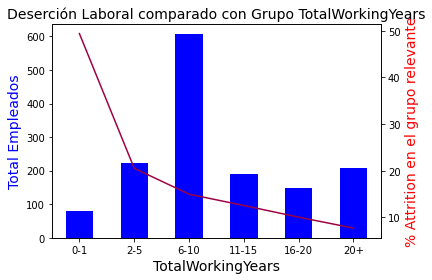

In [1283]:
# Deserción Laboral comparada con la cantidad de años de trabajar en la misma empresa
save_fig("Attrition_TotalWorkingYears_Percent")  # extra code
graph_df(columna = 'TotalWorkingYears', X = df2)

Se observa una dismunución de la deserción laboral a medida que se tiene mayor tiempo de trabajo en la misma empresa. Sin embargo a nivel de la empresa, se tiene la mayor deserción con una experiencie de 6-10 años con un 38.39%.

In [1284]:
#TrainingTimesLastYear
table_df(columna = 'TrainingTimesLastYear', X = df2)
table_df(columna = 'TrainingTimesLastYear', X = df2)

TrainingTimesLastYear  Total TrainingTimesLastYear  \
0                      0                           54   
1                      1                           71   
2                      2                          547   
3                      3                          491   
4                      4                          123   
5                      5                          119   
6                      6                           65   

   # Deserción Laboral(Attrition)  \
0                              15   
1                               9   
2                              98   
3                              69   
4                              26   
5                              14   
6                               6   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          27.777778         
1                                          12.676056         
2                                          17.915905         
3                                          14.052953         
4                                          21.138211         
5                                          11.764706         
6                                           9.230769         

   % de Deserción Laboral en la Compañia  
0                               6.329114  
1                               3.797468  
2                              41.350211  
3                              29.113924  
4                              10.970464  
5                               5.907173  
6                               2.531646

<Figure size 432x288 with 0 Axes>

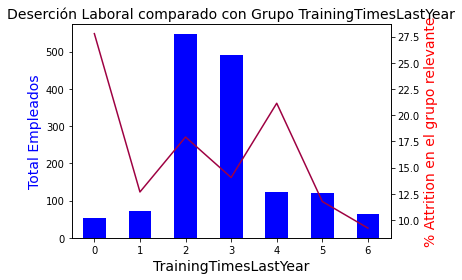

In [1285]:
# Deserción Laboral comparada con la cantidad de entrenamientos en el año anterior
save_fig("Attrition_TrainingTimesLastYear_Percent")  # extra code
graph_df(columna = 'TrainingTimesLastYear', X = df2)

Los empleados que tuvieron 2 y 3 entrenamientos el año anterior tienen el mayor número de deserciones las cuales componen el 70.5% de todas las deserciones en la empresa.

In [1286]:
#WorkLifeBalance
df2['WorkLifeBalance'] = df2['WorkLifeBalance'].map({1:'Bad', 2:'Good', 3:'Better', 4:'Best'})
table_df(columna = 'WorkLifeBalance', X = df2)

WorkLifeBalance  Total WorkLifeBalance  # Deserción Laboral(Attrition)  \
0             Bad                     80                              25   
1            Best                    153                              27   
2          Better                    893                             127   
3            Good                    344                              58   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          31.250000         
1                                          17.647059         
2                                          14.221725         
3                                          16.860465         

   % de Deserción Laboral en la Compañia  
0                              10.548523  
1                              11.392405  
2                              53.586498  
3                              24.472574

<Figure size 432x288 with 0 Axes>

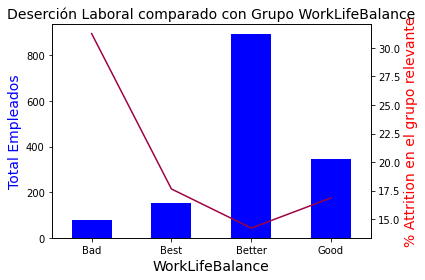

In [1287]:
# Deserción Laboral comparada con el nivel de balance entre la vida y el trabajo
save_fig("Attrition_WorkLifeBalance_Percent")  # extra code
graph_df(columna = 'WorkLifeBalance', X = df2)

A nivel de la clasificación se tiene la mayor deserción con un nivel malo de equilibrio con un 31.25%, sin embargo a nivel de la empresa se tiene mayor deserción las personas que indicaron tener un equilibrio mejor (Better) con un 53.58%.

In [1288]:
#YearsAtCompany
table_df(columna = "YearsAtCompany", X = df2)
bins = [0, 1, 5, 10, 40]
group_names = ['1', '2-5', '6-10', '10+']          
df2['YearsAtCompany'] = pd.cut(employee['YearsAtCompany'], bins, labels = group_names)
table_df(columna = 'YearsAtCompany', X = df2)

YearsAtCompany  Total YearsAtCompany  # Deserción Laboral(Attrition)  \
0              1                   171                              59   
1            2-5                   561                              87   
2           6-10                   448                              55   
3            10+                   246                              20   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          34.502924         
1                                          15.508021         
2                                          12.276786         
3                                           8.130081         

   % de Deserción Laboral en la Compañia  
0                              24.894515  
1                              36.708861  
2                              23.206751  
3                               8.438819

<Figure size 432x288 with 0 Axes>

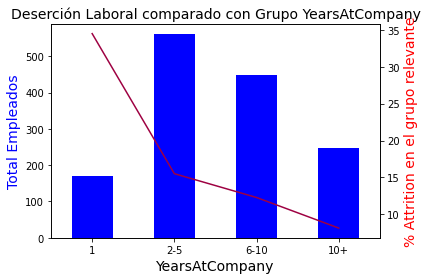

In [1289]:
# Deserción Laboral comparada con el nivel de balance entre la vida y el trabajo
save_fig("Attrition_YearsAtCompany_Percent")  # extra code
graph_df(columna = 'YearsAtCompany', X = df2)

La mayor deserción laboral se encuetra en los empleados del 2-5 años con un 36.70% a nivel de ltoda la compañia. En el grupo de clasificación la mayor deserción es con 1 año de experiencia con el 34.5%.

In [1290]:
#YearsInCurrentRole
table_df(columna = "YearsInCurrentRole", X = df2)
bins = [0, 1, 4, 6, 7, 10, 18]
group_names = ['1', '2-4', '5-6', '7', '8-10', '10+']         
df2['YearsInCurrentRole'] = pd.cut(employee['YearsInCurrentRole'], bins, labels = group_names)
table_df(columna = 'YearsInCurrentRole', X = df2)

YearsInCurrentRole  Total YearsInCurrentRole  \
0                  1                        57   
1                2-4                       611   
2                5-6                        73   
3                  7                       222   
4               8-10                       185   
5                10+                        78   

   # Deserción Laboral(Attrition)  \
0                              11   
1                              99   
2                               3   
3                              31   
4                              15   
5                               5   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          19.298246         
1                                          16.202946         
2                                           4.109589         
3                                          13.963964         
4                                           8.108108         
5                                           6.410256         

   % de Deserción Laboral en la Compañia  
0                               4.641350  
1                              41.772152  
2                               1.265823  
3                              13.080169  
4                               6.329114  
5                               2.109705

<Figure size 432x288 with 0 Axes>

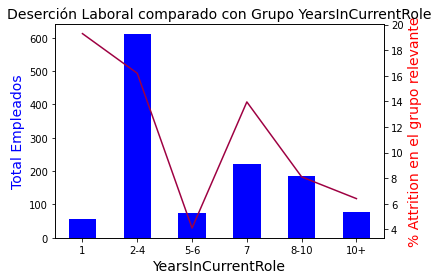

In [1291]:
# Deserción Laboral comparada con los años de trabajo en el mismo puesto
save_fig("Attrition_YearsInCurrentRole_Percent")  # extra code
graph_df(columna = 'YearsInCurrentRole', X = df2)

La mayor desrción laboral ocurre en persona que han durado en el mismo cargo entre 2-4 años con un 41.77% a nivel de la empresa.

In [1292]:
#YearsSinceLastPromotion
table_df(columna = "YearsSinceLastPromotion", X = df2)
bins = [0, 1, 2, 3, 4, 7, 8, 16]
group_names = ['0', '1', '2', '3', '4-6', '7', '8+']      
df2['YearsSinceLastPromotion'] = pd.cut(employee['YearsSinceLastPromotion'], bins, labels = group_names)
table_df(columna = 'YearsSinceLastPromotion', X = df2)

YearsSinceLastPromotion  Total YearsSinceLastPromotion  \
0                       0                            357   
1                       1                            159   
2                       2                             52   
3                       3                             61   
4                     4-6                            153   
5                       7                             18   
6                      8+                             89   

   # Deserción Laboral(Attrition)  \
0                              49   
1                              27   
2                               9   
3                               5   
4                              24   
5                               0   
6                              13   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          13.725490         
1                                          16.981132         
2                                          17.307692         
3                                           8.196721         
4                                          15.686275         
5                                           0.000000         
6                                          14.606742         

   % de Deserción Laboral en la Compañia  
0                              20.675105  
1                              11.392405  
2                               3.797468  
3                               2.109705  
4                              10.126582  
5                               0.000000  
6                               5.485232

<Figure size 432x288 with 0 Axes>

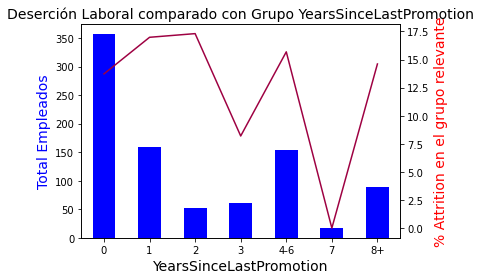

In [1293]:
# Deserción Laboral comparada con los años de trabajo en el mismo puesto
save_fig("Attrition_YearsSinceLastPromotion_Percent")  # extra code
graph_df(columna = 'YearsSinceLastPromotion', X = df2)

Las personas recien egresadas con las que tienen mayor porcentaje de deserción laboral con el 20.67%. a nivel de la compañía.

In [1294]:
#YearsWithCurrManager
table_df(columna = "YearsWithCurrManager", X = df2)
bins = [0, 1, 2, 3, 4, 7, 8, 16]
group_names = ['0', '1', '2', '3', '4-6', '7', '8+']      
df2['YearsWithCurrManager'] = pd.cut(employee['YearsWithCurrManager'], bins, labels = group_names)
table_df(columna = 'YearsWithCurrManager', X = df2)

YearsWithCurrManager  Total YearsWithCurrManager  \
0                    0                          76   
1                    1                         344   
2                    2                         142   
3                    3                          98   
4                  4-6                         276   
5                    7                         107   
6                   8+                         157   

   # Deserción Laboral(Attrition)  \
0                              11   
1                              50   
2                              19   
3                              11   
4                              39   
5                              10   
6                              12   

   % de Deserción Laboral(Attrition) en el grupo relevante  \
0                                          14.473684         
1                                          14.534884         
2                                          13.380282         
3                                          11.224490         
4                                          14.130435         
5                                           9.345794         
6                                           7.643312         

   % de Deserción Laboral en la Compañia  
0                               4.641350  
1                              21.097046  
2                               8.016878  
3                               4.641350  
4                              16.455696  
5                               4.219409  
6                               5.063291

<Figure size 432x288 with 0 Axes>

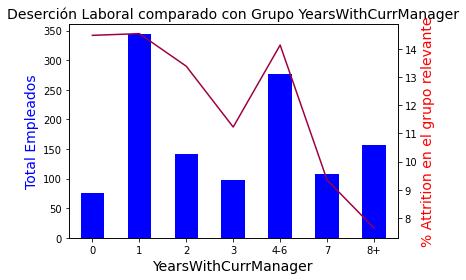

In [1295]:
# Deserción Laboral comparada con los años con el mismo jefe
save_fig("Attrition_YearsWithCurrManager_Percent")  # extra code
graph_df(columna = 'YearsWithCurrManager', X = df2)

La mayor deserción laboral de produjo cuando trabajaban con el mismo jefe durante 1 año con el 21.09% a nivel de la empresa.

In [1296]:
employee = employee.drop(columns=['DailyRate'])
df2 = df2.drop(columns=['DailyRate'])

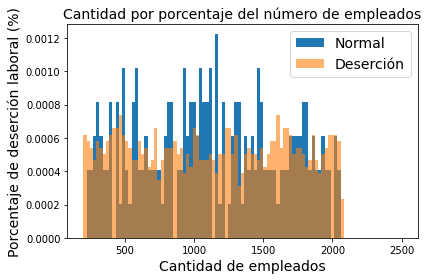

In [1297]:
#EmployeeNumber
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df["EmployeeNumber"], bins, alpha=1, density=True, label='Normal')
plt.hist(attrition_df["EmployeeNumber"], bins, alpha=0.6, density=True, label='Deserción')
plt.legend(loc='upper right')
plt.title("Cantidad por porcentaje del número de empleados")
plt.xlabel("Cantidad de empleados")
plt.ylabel("Porcentaje de deserción laboral (%)");
save_fig("employeenumber_attrion")  # extra code
plt.show()

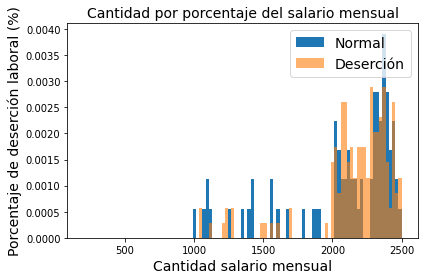

In [1298]:
#MonthlyIncome
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df["MonthlyIncome"], bins, alpha=1, density=True, label='Normal')
plt.hist(attrition_df["MonthlyIncome"], bins, alpha=0.6, density=True, label='Deserción')
plt.legend(loc='upper right')
plt.title("Cantidad por porcentaje del salario mensual")
plt.xlabel("Cantidad salario mensual")
plt.ylabel("Porcentaje de deserción laboral (%)");
save_fig("monthlyincome_attrion")  # extra code
plt.show()

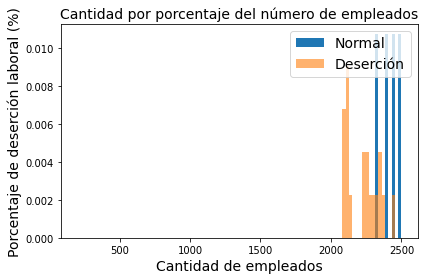

In [1299]:
#MonthlyRate
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df["MonthlyRate"], bins, alpha=1, density=True, label='Normal')
plt.hist(attrition_df["MonthlyRate"], bins, alpha=0.6, density=True, label='Deserción')
plt.legend(loc='upper right')
plt.title("Cantidad por porcentaje del número de empleados")
plt.xlabel("Cantidad de empleados")
plt.ylabel("Porcentaje de deserción laboral (%)");
save_fig("monthlyrate_attrion")  # extra code
plt.show()

Se realiza la visualización de la proporción de datos para cada variable categórica

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64

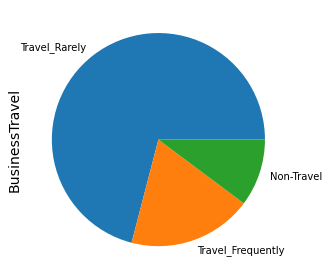

In [1300]:
employee["BusinessTravel"].value_counts().plot(kind='pie')
save_fig("BusinessTravel_count")  # extra code
employee["BusinessTravel"].value_counts()

* "BusinessTravel" se clasifica como una variable Categórica - Nominal

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

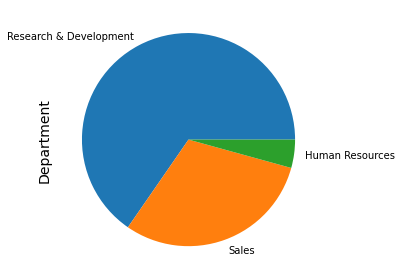

In [1301]:
employee["Department"].value_counts().plot(kind='pie')
save_fig("Department_count")  # extra code
employee["Department"].value_counts()

* "Department" se clasifica como una variable Categórica - Nominal

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

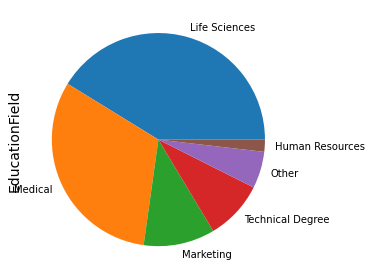

In [1302]:
employee["EducationField"].value_counts().plot(kind='pie')
save_fig("EducationField_count")  # extra code
employee["EducationField"].value_counts()

* "EducationField" se clasifica como una variable Categórica - Nominal

Male      882
Female    588
Name: Gender, dtype: int64

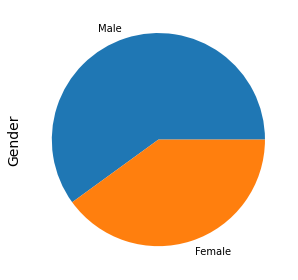

In [1303]:
employee["Gender"].value_counts().plot(kind='pie')
save_fig("Gender_count")  # extra code
employee["Gender"].value_counts()

* "Gender" se clasifica como una variable Categórica - Nominal

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

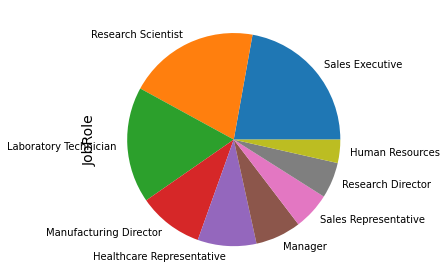

In [1304]:
employee["JobRole"].value_counts().plot(kind='pie')
save_fig("JobRole_count")  # extra code
employee["JobRole"].value_counts()

"JobRole" se clasifica como una variable Categórica - Nominal

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

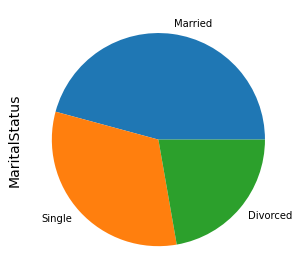

In [1305]:
employee["MaritalStatus"].value_counts().plot(kind='pie')
save_fig("MaritalStatus_count")  # extra code
employee["MaritalStatus"].value_counts()

* "MaritalStatus" se clasifica como una variable Categórica - Nominal

No     1054
Yes     416
Name: OverTime, dtype: int64

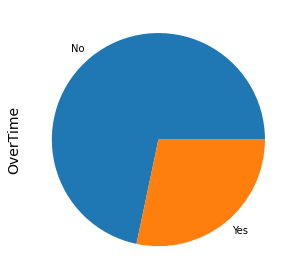

In [1306]:
employee["OverTime"].value_counts().plot(kind='pie')
save_fig("OverTime_count")  # extra code
employee["OverTime"].value_counts()

* "OverTime" se clasifica como una variable Categórica - Binaria



In [1307]:
employee["Over18"].value_counts()

Y    1470
Name: Over18, dtype: int64

* "Over18" se clasifica como una variable Categórica - Binaria.<br>

* De acuerdo con la clasificación, la variable "**Over18**" no es relevante ya que no presenta variación en alguna de las instacias del conjunto de datos.

Resumen de los atributos numéricos:

In [1308]:
employee.describe()

Age  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810          9.192517     2.912925            1.0   
std       9.135373          8.106864     1.024165            0.0   
min      18.000000          1.000000     1.000000            1.0   
25%      30.000000          2.000000     2.000000            1.0   
50%      36.000000          7.000000     3.000000            1.0   
75%      43.000000         14.000000     4.000000            1.0   
max      60.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.729932   
std        602.024335                 1.093082    20.329428        0.711561   
min          1.000000                 1.000000    30.000000        1.000000   
25%        491.250000                 2.000000    48.000000        2.000000   
50%       1020.500000                 3.000000    66.000000        3.000000   
75%       1555.750000                 4.000000    83.750000        3.000000   
max       2068.000000                 4.000000   100.000000        4.000000   

          JobLevel  JobSatisfaction  ...  RelationshipSatisfaction  \
count  1470.000000      1470.000000  ...               1470.000000   
mean      2.063946         2.728571  ...                  2.712245   
std       1.106940         1.102846  ...                  1.081209   
min       1.000000         1.000000  ...                  1.000000   
25%       1.000000         2.000000  ...                  2.000000   
50%       2.000000         3.000000  ...                  3.000000   
75%       3.000000         4.000000  ...                  4.000000   
max       5.000000         4.000000  ...                  4.000000   

       StandardHours  StockOptionLevel  TotalWorkingYears  \
count         1470.0       1470.000000        1470.000000   
mean            80.0          0.793878          11.279592   
std              0.0          0.852077           7.780782   
min             80.0          0.000000           0.000000   
25%             80.0          0.000000           6.000000   
50%             80.0          1.000000          10.000000   
75%             80.0          1.000000          15.000000   
max             80.0          3.000000          40.000000   

       TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
count            1470.000000      1470.000000     1470.000000   
mean                2.799320         2.761224        7.008163   
std                 1.289271         0.706476        6.126525   
min                 0.000000         1.000000        0.000000   
25%                 2.000000         2.000000        3.000000   
50%                 3.000000         3.000000        5.000000   
75%                 3.000000         3.000000        9.000000   
max                 6.000000         4.000000       40.000000   

       YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
count         1470.000000              1470.000000           1470.000000  
mean             4.229252                 2.187755              4.123129  
std              3.623137                 3.222430              3.568136  
min              0.000000                 0.000000              0.000000  
25%              2.000000                 0.000000              2.000000  
50%              3.000000                 1.000000              3.000000  
75%              7.000000                 3.000000              7.000000  
max             18.000000                15.000000             17.000000  

[8 rows x 25 columns]

In [1309]:
duplicate = employee[employee.duplicated()]
duplicate

Empty DataFrame
Columns: [Age, Attrition, BusinessTravel, Department, DistanceFromHome, Education, EducationField, EmployeeCount, EmployeeNumber, EnvironmentSatisfaction, Gender, HourlyRate, JobInvolvement, JobLevel, JobRole, JobSatisfaction, MaritalStatus, MonthlyIncome, MonthlyRate, NumCompaniesWorked, Over18, OverTime, PercentSalaryHike, PerformanceRating, RelationshipSatisfaction, StandardHours, StockOptionLevel, TotalWorkingYears, TrainingTimesLastYear, WorkLifeBalance, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager]
Index: []

[0 rows x 34 columns]

Entender la distribución de los datos:

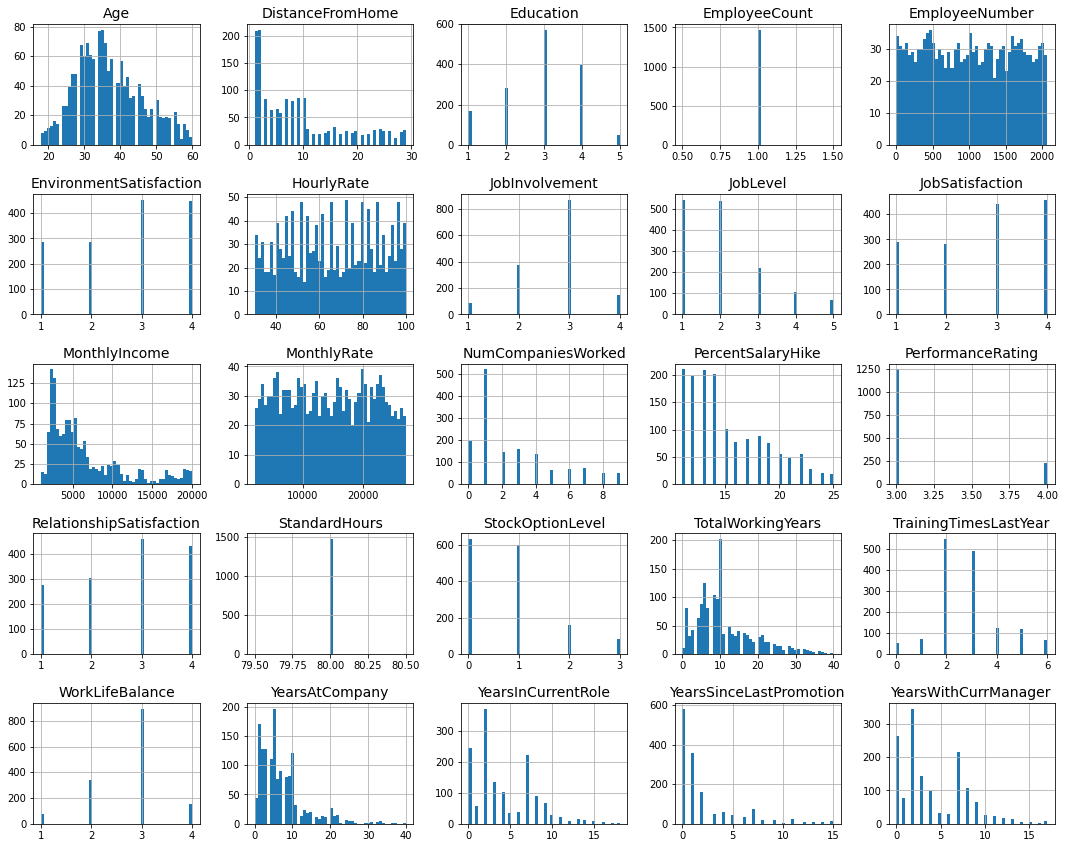

In [1310]:
import matplotlib.pyplot as plt

# código extra - las siguientes 5 líneas definen los tamaños de fuente por defecto
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

employee.hist(bins=50, figsize=(15, 12))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

In [1311]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EmployeeCount             1470 non-null   int64 
 8   EmployeeNumber            1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

In [1312]:
#Mover la variable objetivo al final
front = employee['Attrition']
employee.drop(labels=['Attrition'], axis=1,inplace=True)
employee.insert(employee.columns.shape[0],'Attrition',front)
employee.head()

Age     BusinessTravel              Department  DistanceFromHome  \
0   41      Travel_Rarely                   Sales                 1   
1   49  Travel_Frequently  Research & Development                 8   
2   37      Travel_Rarely  Research & Development                 2   
3   33  Travel_Frequently  Research & Development                 3   
4   27      Travel_Rarely  Research & Development                 2   

   Education EducationField  EmployeeCount  EmployeeNumber  \
0          2  Life Sciences              1               1   
1          1  Life Sciences              1               2   
2          2          Other              1               4   
3          4  Life Sciences              1               5   
4          1        Medical              1               7   

   EnvironmentSatisfaction  Gender  ...  StandardHours  StockOptionLevel  \
0                        2  Female  ...             80                 0   
1                        3    Male  ...             80                 1   
2                        4    Male  ...             80                 0   
3                        4  Female  ...             80                 0   
4                        1    Male  ...             80                 1   

   TotalWorkingYears TrainingTimesLastYear  WorkLifeBalance YearsAtCompany  \
0                  8                     0                1              6   
1                 10                     3                3             10   
2                  7                     3                3              0   
3                  8                     3                3              8   
4                  6                     3                3              2   

   YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager Attrition  
0                   4                        0                     5       Yes  
1                   7                        1                     7        No  
2                   0                        0                     0       Yes  
3                   7                        3                     0        No  
4                   2                        2                     2        No  

[5 rows x 34 columns]

## Descubrir y visualizar los datos para obtener información (insights)

- Transformación de las variables

In [1313]:
df= employee.copy() #se saca una copia al dataset original

In [1314]:
categoricas1 = ['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus']

In [1315]:
categoricas2 = ['OverTime']

In [1316]:
for col in categoricas1:
    df = pd.concat([df, (pd.get_dummies(df[col])).astype(int)], axis=1) #con get_dummies se hace el One-Hot Encoder
    df.drop(columns=[col],inplace=True)

In [1317]:
for col in categoricas2:
  df[col] = df[col].apply(lambda x: 0 if x == 'No' else 1)

In [1318]:
df['Attrition'] = df['Attrition'].replace({'No':0, 'Yes':1})

In [1319]:
#eliminar características con valores únicos
df = df.drop(['Over18', 'StandardHours', 'EmployeeCount', 'EmployeeNumber'], axis = 1)

In [1320]:
print(df.shape)
df.head(3)

(1470, 50)


Age  DistanceFromHome  Education  EnvironmentSatisfaction  HourlyRate  \
0   41                 1          2                        2          94   
1   49                 8          1                        3          61   
2   37                 2          2                        4          92   

   JobInvolvement  JobLevel  JobSatisfaction  MonthlyIncome  MonthlyRate  ...  \
0               3         2                4           5993        19479  ...   
1               2         2                2           5130        24907  ...   
2               2         1                3           2090         2396  ...   

   Laboratory Technician  Manager  Manufacturing Director  Research Director  \
0                      0        0                       0                  0   
1                      0        0                       0                  0   
2                      1        0                       0                  0   

   Research Scientist  Sales Executive  Sales Representative  Divorced  \
0                   0                1                     0         0   
1                   1                0                     0         0   
2                   0                0                     0         0   

   Married  Single  
0        0       1  
1        1       0  
2        0       1  

[3 rows x 50 columns]

In [1321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Age                        1470 non-null   int64
 1   DistanceFromHome           1470 non-null   int64
 2   Education                  1470 non-null   int64
 3   EnvironmentSatisfaction    1470 non-null   int64
 4   HourlyRate                 1470 non-null   int64
 5   JobInvolvement             1470 non-null   int64
 6   JobLevel                   1470 non-null   int64
 7   JobSatisfaction            1470 non-null   int64
 8   MonthlyIncome              1470 non-null   int64
 9   MonthlyRate                1470 non-null   int64
 10  NumCompaniesWorked         1470 non-null   int64
 11  OverTime                   1470 non-null   int64
 12  PercentSalaryHike          1470 non-null   int64
 13  PerformanceRating          1470 non-null   int64
 14  RelationshipSatisfaction

In [1322]:
X = df.drop(columns=['Attrition'])
y = df['Attrition']

**Árboles de descisión para validar la clasificación de las variables que tienen mayor correlación con la variable objetivo**

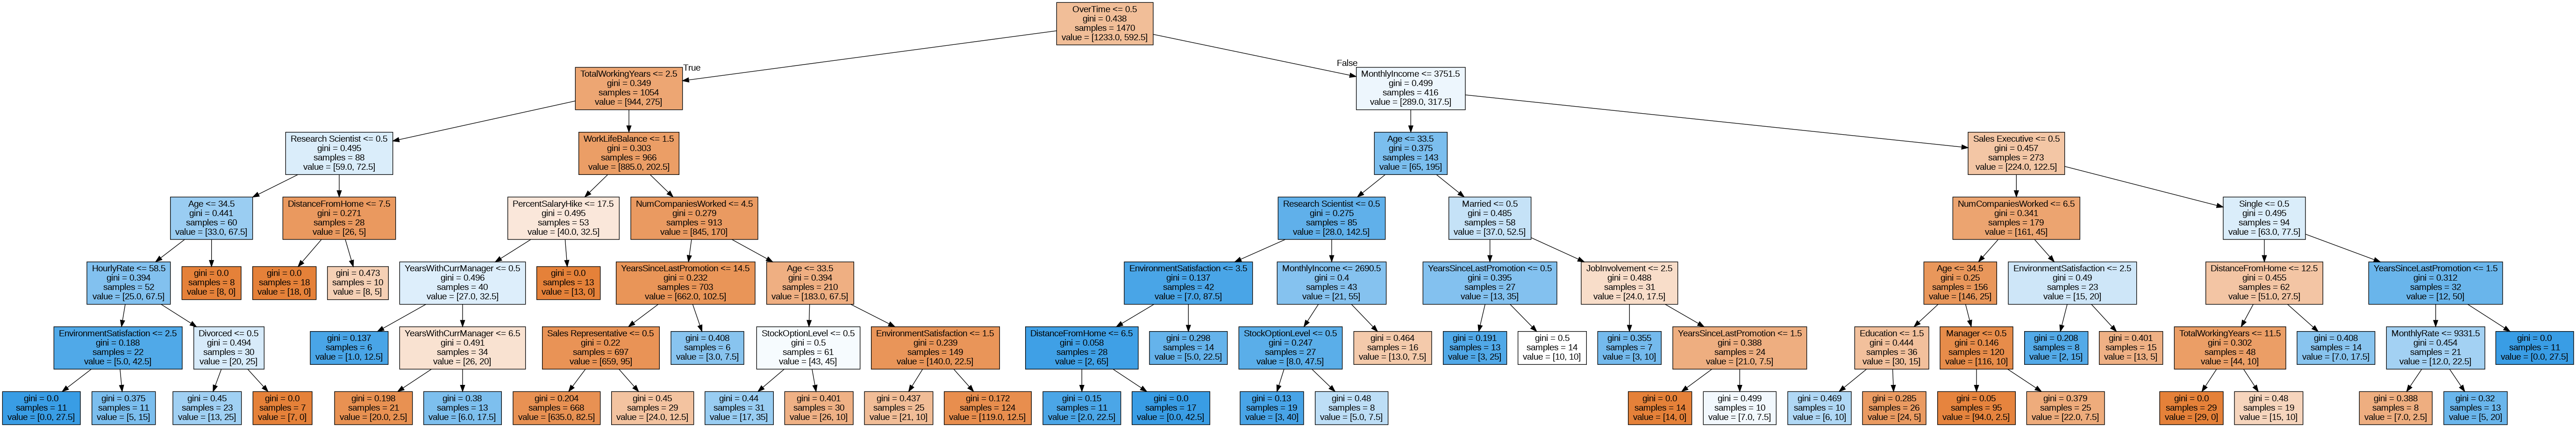

In [1323]:
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
from subprocess import check_call
from IPython.display import Image as PImage
%matplotlib inline 

# Crear Arbol de decision con profundidad = 6  
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 6,
                                            class_weight={1:2.5})

decision_tree.fit(X, y)
                  
# exportar el modelo a archivo .dot
with open(r"images/end_to_end_project/arbol_decision.dot", 'w') as f:
  f = open("images/end_to_end_project/arbol_decision.dot", 'w')
  tree.export_graphviz(decision_tree, out_file = f, feature_names = X.columns, filled=True)
  f.close()
  
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'images/end_to_end_project/arbol_decision.dot','-o',r'images/end_to_end_project/arbol_decision.png'])
PImage("images/end_to_end_project/arbol_decision.png")

Esta es una visión general de la correlación que existe entre las variables a evaluar y la variable objetivo. Partiendo por el valor más alto de GINE en los nodos se puede determinar que la rama con variables:<br>
"OverTime", "TotalWorkingYears", "Research SCientist", "Age", "HourlyRate" y "EnvironmentSatisfaction" son las que poseen la mejor alternativa a evaluar para enncontrar los factores de mayor peso en la deserción laboral.

##Preprocesamiento

In [1324]:
def one_hot_encoder(df, column):
  df = df.copy()
  dummies = pd.get_dummies(df[column], prefix=column)
  df = pd.concat([df, dummies.astype(int)], axis = 1)
  df = df.drop(column, axis = 1)

  return df

In [1325]:
def simple_imputer(df, column):
  df = df.copy()
  imputer = SimpleImputer(strategy='mean')
  data = df[column].values

  min_max = MinMaxScaler()
  scaled_data = min_max.fit_transform(data.reshape(-1,1))

  df[column] = imputer.fit_transform(scaled_data)

  return df

In [1326]:
def preprocesamiento(df):
  df = df.copy()

  #eliminar características con valores únicos:
  df = df.drop(['Over18', 'StandardHours', 'EmployeeCount', 'EmployeeNumber'], axis = 1)

  #normalizar las variables numéricas:
  numerical_columns = df.select_dtypes(include=np.number).columns 
  for column in numerical_columns:
    df = simple_imputer(df, column=column)

  #codificar variables categóricas binarias:
  df['OverTime'] = df['OverTime'].replace({'No':0, 'Yes':1})
  df['Attrition'] = df['Attrition'].replace({'No':0, 'Yes':1})

  #codificar variables categóricas ordinales:
  df['BusinessTravel'] = df['BusinessTravel'].replace({'Non-Travel':0, 'Travel_Rarely':1, 'Travel_Frequently':2}) 

  #codificar variables categóricas nominales:
  cat_ord = ['Gender','Department','EducationField','JobRole','MaritalStatus']
  for column in cat_ord:
    df = one_hot_encoder(df, column=column)

  X = df.drop(columns=['Attrition'])
  y = df['Attrition']

  return X, y

In [1327]:
X, y = preprocesamiento(employee)

Calcular el coeficiente de correlación estándar:

In [1328]:
df3 = X.copy()
df3['Attrition'] = y.copy()
corr_matrix = df3.corr()
corr_matrix

Age  BusinessTravel  DistanceFromHome  \
Age                                1.000000       -0.011807         -0.001686   
BusinessTravel                    -0.011807        1.000000         -0.009696   
DistanceFromHome                  -0.001686       -0.009696          1.000000   
Education                          0.208034       -0.008670          0.021042   
EnvironmentSatisfaction            0.010146       -0.011310         -0.016075   
HourlyRate                         0.024287       -0.004164          0.031131   
JobInvolvement                     0.029820        0.029300          0.008783   
JobLevel                           0.509604       -0.011696          0.005303   
JobSatisfaction                   -0.004892        0.008666         -0.003669   
MonthlyIncome                      0.497855       -0.013450         -0.017014   
MonthlyRate                        0.028051       -0.008440          0.027473   
NumCompaniesWorked                 0.299635       -0.030743         -0.029251   
OverTime                           0.028062        0.042752          0.025514   
PercentSalaryHike                  0.003634       -0.025727          0.040235   
PerformanceRating                  0.001904        0.001683          0.027110   
RelationshipSatisfaction           0.053535        0.008926          0.006557   
StockOptionLevel                   0.037510       -0.028257          0.044872   
TotalWorkingYears                  0.680381        0.007972          0.004628   
TrainingTimesLastYear             -0.019621        0.016357         -0.036942   
WorkLifeBalance                   -0.021490        0.004209         -0.026556   
YearsAtCompany                     0.311309        0.005212          0.009508   
YearsInCurrentRole                 0.212901       -0.005336          0.018845   
YearsSinceLastPromotion            0.216513        0.005222          0.010029   
YearsWithCurrManager               0.202089       -0.000229          0.014406   
Gender_Female                      0.036311        0.044896          0.001851   
Gender_Male                       -0.036311       -0.044896         -0.001851   
Department_Human Resources         0.020523       -0.002796         -0.012901   
Department_Research & Development  0.017883        0.005308         -0.008117   
Department_Sales                  -0.027549       -0.004261          0.014085   
EducationField_Human Resources     0.001696       -0.003168         -0.002624   
EducationField_Life Sciences       0.016824        0.019860         -0.024499   
EducationField_Marketing           0.038162        0.005201          0.039294   
EducationField_Medical            -0.006354       -0.011245          0.013486   
EducationField_Other              -0.041466       -0.000470         -0.007969   
EducationField_Technical Degree   -0.027604       -0.019699         -0.014802   
JobRole_Healthcare Representative  0.098825       -0.001426          0.022916   
JobRole_Human Resources           -0.029856        0.010435         -0.024089   
JobRole_Laboratory Technician     -0.143176        0.002094          0.012369   
JobRole_Manager                    0.294248       -0.039312         -0.039190   
JobRole_Manufacturing Director     0.049726        0.014893          0.011848   
JobRole_Research Director          0.185891       -0.005138         -0.022351   
JobRole_Research Scientist        -0.146518        0.002477         -0.010986   
JobRole_Sales Executive           -0.002001       -0.025131          0.030761   
JobRole_Sales Representative      -0.175785        0.059995         -0.015994   
MaritalStatus_Divorced             0.033120       -0.028444         -0.005440   
MaritalStatus_Married              0.083919        0.002198          0.030232   
MaritalStatus_Single              -0.119185        0.023017         -0.027445   
Attrition                         -0.159205        0.127006          0.077924   

                                   Education  EnvironmentSatisfaction 

<Axes: >

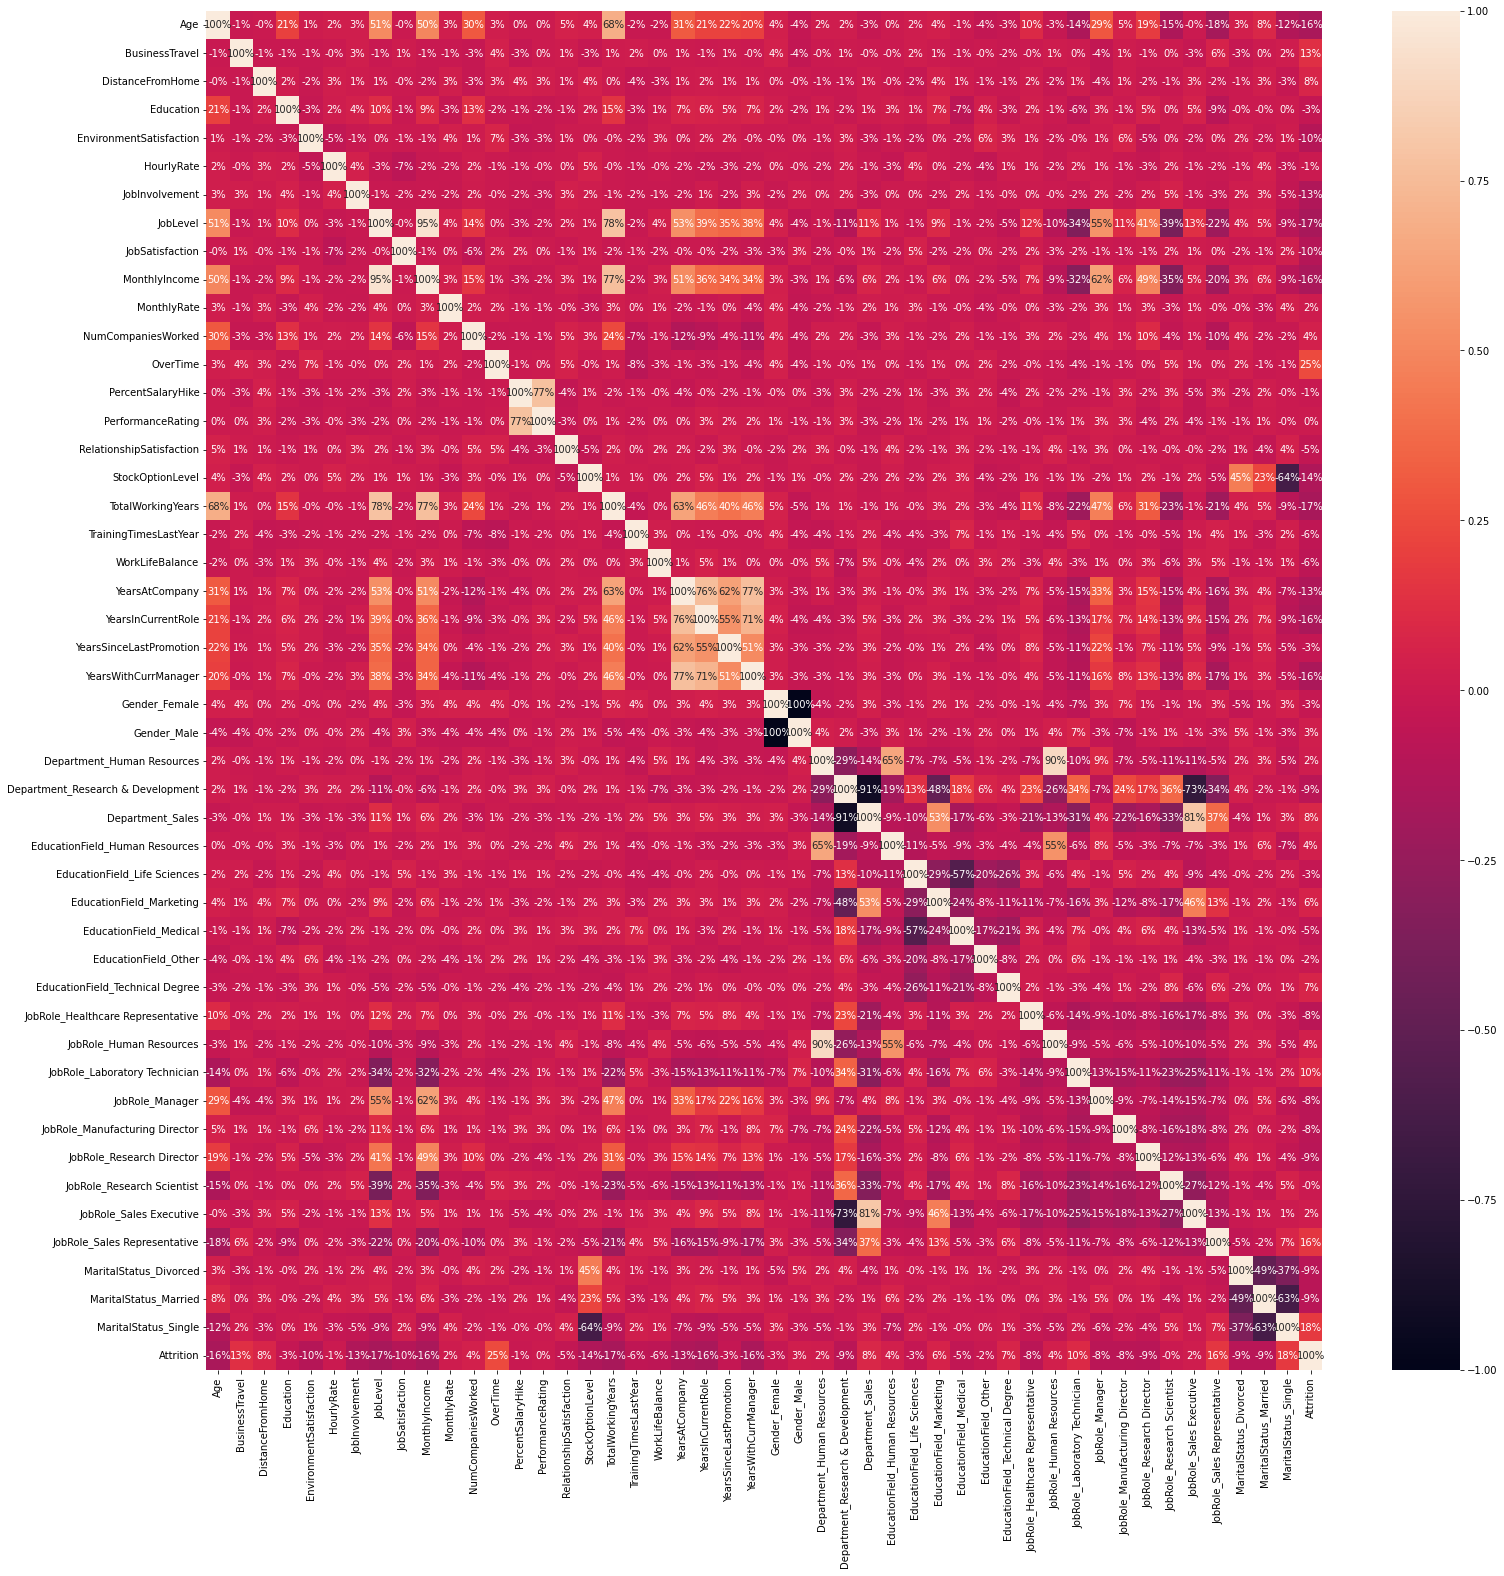

In [1329]:
plt.figure(figsize=(25,25))
save_fig("matriz_correlacion")  # extra code
sns.heatmap(corr_matrix, annot=True, fmt='.0%')

Correlación de los datos con la variable "Attrition"

In [1330]:
corr_matrix["Attrition"].sort_values(ascending=False)

Attrition                            1.000000
OverTime                             0.246118
MaritalStatus_Single                 0.175419
JobRole_Sales Representative         0.157234
BusinessTravel                       0.127006
JobRole_Laboratory Technician        0.098290
Department_Sales                     0.080855
DistanceFromHome                     0.077924
EducationField_Technical Degree      0.069355
EducationField_Marketing             0.055781
NumCompaniesWorked                   0.043494
EducationField_Human Resources       0.036466
JobRole_Human Resources              0.036215
Gender_Male                          0.029453
JobRole_Sales Executive              0.019774
Department_Human Resources           0.016832
MonthlyRate                          0.015170
PerformanceRating                    0.002889
JobRole_Research Scientist          -0.000360
HourlyRate                          -0.006846
PercentSalaryHike                   -0.013478
EducationField_Other              

A partir de la correlación casi nula de algunas características respecto a la deserción laboral, se deciden eliminar del conjunto de variables a evaluar las variables con correlación abs(value) < 0.02:

In [1331]:
X = X.drop(['JobRole_Sales Executive', 'Department_Human Resources', 'MonthlyRate', 'PerformanceRating','JobRole_Research Scientist','HourlyRate','PercentSalaryHike','EducationField_Other'], axis = 1)

Reducir el conjunto de datos a 2 dimensiones para visualizarlos

Text(0.5, 1.0, 'Número de observaciones por clase')

<Figure size 432x288 with 0 Axes>

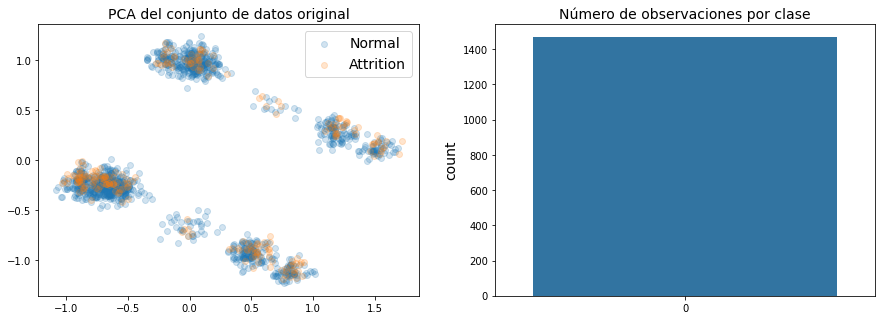

In [1332]:
save_fig("PCA del conjunto de datos original")  # extra code
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="Normal", alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="Attrition", alpha=0.2)
ax[0].set_title('PCA del conjunto de datos original')
ax[0].legend()

ax[1] = sns.countplot(y)
ax[1].set_title('Número de observaciones por clase')

## Crear un conjunto de pruebas (Test Set)

Se crea el conjunto de datos de entrenamiento del 80% de los datos y el conjunto de datos de pruebas con el 20% estratificado por la variable de objetivo para conservar el comportamiento de cada conjunto de datos respecto al conjunto de datos original:

In [1333]:
from sklearn.model_selection import train_test_split #Divisor de los datos de entrenamiento 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40) #random_state -> semilla

#Técnicas de Deep learning

###Regresión logística

In [1334]:
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=40,solver="newton-cg") #devuelve el clasificador entrenado C->regularización que impide que el método se sobreajuste, l2->distancia cuadrática, solver->minimiza el error
    clf_base.fit(X_train, y_train)
    return clf_base

###Modelo Sin Balancear

In [1335]:
model = []
model = run_model(X_train, X_test, y_train, y_test)

A continuación, se define una función que muestra la matriz de confusión y un informe de clasificación:

In [1336]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase prevista')
    plt.show()
    report = classification_report(y_test, pred_y, output_dict=True)
    print (pd.DataFrame(report).transpose())

<Figure size 432x288 with 0 Axes>

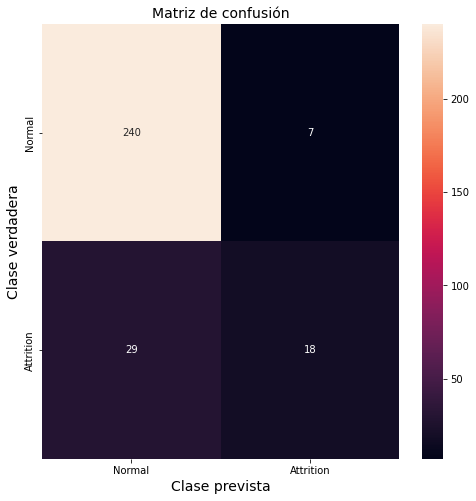

              precision    recall  f1-score     support
0              0.892193  0.971660  0.930233  247.000000
1              0.720000  0.382979  0.500000   47.000000
accuracy       0.877551  0.877551  0.877551    0.877551
macro avg      0.806097  0.677319  0.715116  294.000000
weighted avg   0.864666  0.877551  0.861454  294.000000


In [1337]:
pred_y = model.predict(X_test)
save_fig("Matriz_Confusion_Regresion_logistica")  # extra code
mostrar_resultados(y_test, pred_y)

Almaceno el reporte de clafificación para realizar una comparación con otros modelos:

In [1338]:
clsf_report_mod0 = pd.DataFrame(classification_report(y_test, pred_y, output_dict=True)).transpose()
regresion_logistica_accuracy = clsf_report_mod0['precision'][2] * 100

In [1339]:
regresion_logistica_accuracy

87.75510204081633

Se presenta la matriz de confusión, y en particular se enfoca en la clase 2 (Attrition), que es la que se quiere detectar. <br>
Se observan 29 falsos negativos y 18 verdaderos positivos, lo que resulta en un recall de 0.38, un valor que se desea mejorar. Es importante destacar que el modelo no es capaz de detectar correctamente los casos de fraude.

##Validación del balanceo de clases

1. Estrategia: Penalización para compensar



In [1340]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2', random_state=40, solver="newton-cg", class_weight="balanced") #class_weight -> balancea el peso de las clases
    clf.fit(X_train, y_train)
    return clf

In [1341]:
model = []
model = run_model_balanced(X_train, X_test, y_train, y_test)

Se valida el resultado

<Figure size 432x288 with 0 Axes>

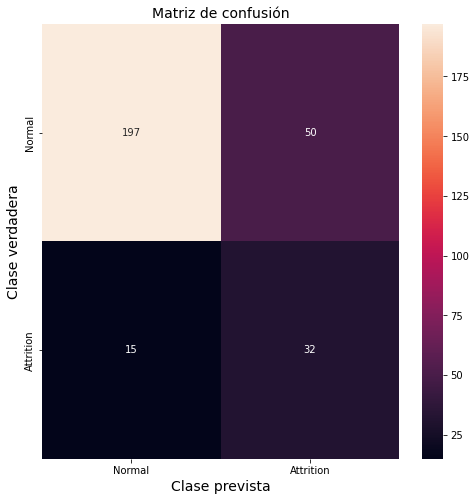

              precision    recall  f1-score     support
0              0.929245  0.797571  0.858388  247.000000
1              0.390244  0.680851  0.496124   47.000000
accuracy       0.778912  0.778912  0.778912    0.778912
macro avg      0.659745  0.739211  0.677256  294.000000
weighted avg   0.843078  0.778912  0.800475  294.000000


In [1342]:
pred_y = model.predict(X_test)
save_fig("Matriz_Confusion_Penalizacion")  # extra code
mostrar_resultados(y_test, pred_y)

Al incorporar esta modificación, se ha obtenido una significativa mejora en la detección de casos de deserción laboral, específicamente en la clase 2 (Attrition), que representa si hubo deserción laboral.<br> 
Se han acertado 32 muestras y se han fallado en 15, obteniendo un recall de 0.68.

Almaceno el reporte de clafificación para realizar una comparación con otros modelos:

In [1343]:
clsf_report_mod1 = pd.DataFrame(classification_report(y_test, pred_y, output_dict=True)).transpose()
clsf_report_mod1['precision'][2] * 100

77.89115646258503

2. Estrategia: Subsampling en la clase mayoritaria

In [1344]:
us = NearMiss(sampling_strategy=0.5, n_neighbors=3, version=2) #sampling_strategy -> % al que quiero llegar distribución entre clases version->tipo de NearMiss, aquí NearMiss-2
X_train_res, y_train_res = us.fit_resample(X_train, y_train)

print ("Distribución de las etiquetas de clase antes del resampling {}".format(Counter(y_train)))
print ("Distribución de las etiquetas de clase despues del  resampling {}".format(Counter(y_train_res)))

Distribución de las etiquetas de clase antes del resampling Counter({0: 986, 1: 190})
Distribución de las etiquetas de clase despues del  resampling Counter({0: 380, 1: 190})


In [1345]:
model = []
model = run_model(X_train_res, X_test, y_train_res, y_test)

Se validan los resultados

<Figure size 432x288 with 0 Axes>

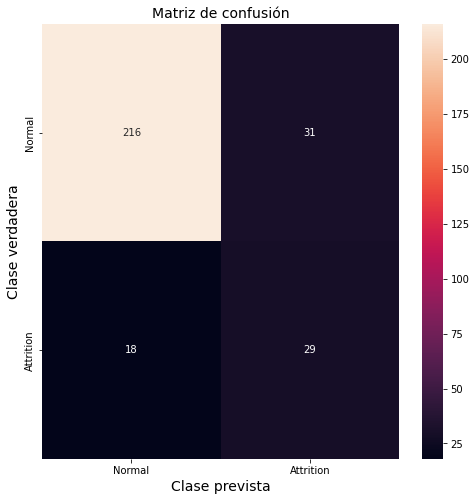

              precision    recall  f1-score     support
0              0.923077  0.874494  0.898129  247.000000
1              0.483333  0.617021  0.542056   47.000000
accuracy       0.833333  0.833333  0.833333    0.833333
macro avg      0.703205  0.745758  0.720092  294.000000
weighted avg   0.852778  0.833333  0.841206  294.000000


In [1346]:
pred_y = model.predict(X_test)
save_fig("Matriz_Confusion_Subsampling")  # extra code
mostrar_resultados(y_test, pred_y)

Aumentó un poco el recall a 0.62, con respecto al método de penalización.

Almaceno el reporte de clafificación para realizar una comparación con otros modelos:

In [1347]:
clsf_report_mod2 = pd.DataFrame(classification_report(y_test, pred_y, output_dict=True)).transpose()
clsf_report_mod2['precision'][2] * 100

83.33333333333334

3. Estrategia: Random Oversampling de la clase minoritaria

In [1348]:
os =  RandomOverSampler(sampling_strategy=0.5)
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

print ("Distribución de las etiquetas de clase antes del resampling {}".format(Counter(y_train)))
print ("Distribución de las etiquetas de clase despues del  resampling {}".format(Counter(y_train_res)))

Distribución de las etiquetas de clase antes del resampling Counter({0: 986, 1: 190})
Distribución de las etiquetas de clase despues del  resampling Counter({0: 986, 1: 493})


In [1349]:
model = []
model = run_model(X_train_res, X_test, y_train_res, y_test)

Se valida el resultado

<Figure size 432x288 with 0 Axes>

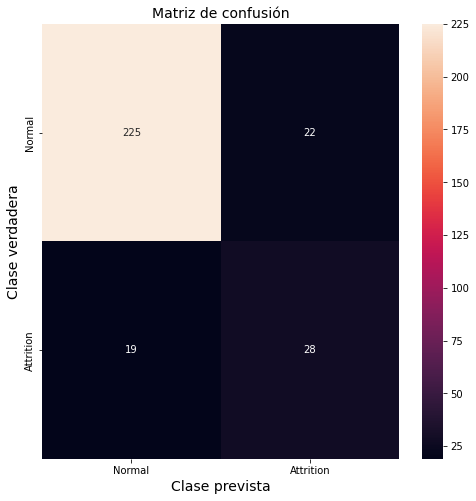

              precision    recall  f1-score     support
0              0.922131  0.910931  0.916497  247.000000
1              0.560000  0.595745  0.577320   47.000000
accuracy       0.860544  0.860544  0.860544    0.860544
macro avg      0.741066  0.753338  0.746908  294.000000
weighted avg   0.864239  0.860544  0.862275  294.000000


In [1350]:
pred_y = model.predict(X_test)
save_fig("Matriz_Confusion_RandomOverSampler")  # extra code
mostrar_resultados(y_test, pred_y)

Se obtiene el recall en 0.60 pero disminuyeron los falsos negativos y los falsos positivos.

Almaceno el reporte de clafificación para realizar una comparación con otros modelos:

In [1351]:
clsf_report_mod3 = pd.DataFrame(classification_report(y_test, pred_y, output_dict=True)).transpose()
clsf_report_mod3['precision'][2] * 100

86.05442176870748

4. Estrategia: Combinamos resampling con Smote-Tomek

In [1352]:
os_us = SMOTETomek(sampling_strategy=0.5)
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)

print ("Distribución de las etiquetas de clase antes del resampling {}".format(Counter(y_train)))
print ("Distribución de las etiquetas de clase despues del  resampling {}".format(Counter(y_train_res)))

Distribución de las etiquetas de clase antes del resampling Counter({0: 986, 1: 190})
Distribución de las etiquetas de clase despues del  resampling Counter({0: 976, 1: 483})


In [1353]:
model = []
model = run_model(X_train_res, X_test, y_train_res, y_test)

Se evalua el resultado

<Figure size 432x288 with 0 Axes>

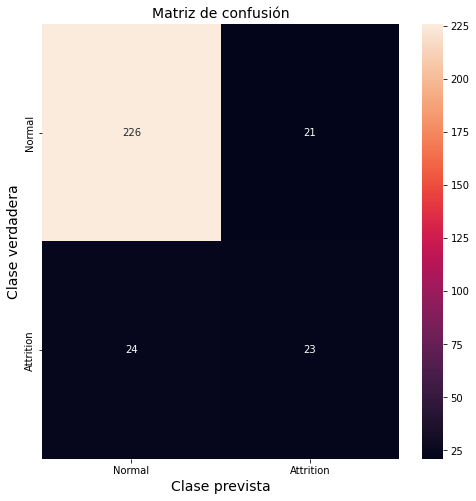

              precision    recall  f1-score     support
0              0.904000  0.914980  0.909457  247.000000
1              0.522727  0.489362  0.505495   47.000000
accuracy       0.846939  0.846939  0.846939    0.846939
macro avg      0.713364  0.702171  0.707476  294.000000
weighted avg   0.843048  0.846939  0.844878  294.000000


In [1354]:
pred_y = model.predict(X_test)
save_fig("Matriz_Confusion_SmoteTomek")  # extra code
mostrar_resultados(y_test, pred_y)

Se obtiene un recall de 0.53 para la clase 2 y se observa que hay pocos falsos positivos de la clase 1, 22 de 247 muestras.

Almaceno el reporte de clafificación para realizar una comparación con otros modelos:

In [1355]:
clsf_report_mod4 = pd.DataFrame(classification_report(y_test, pred_y, output_dict=True)).transpose()
clsf_report_mod4['precision'][2] * 100

84.6938775510204

5. Estrategia: Ensamble de Modelos con Balanceo

In [1356]:
from imblearn.ensemble import BalancedBaggingClassifier

# Crear un objeto del clasificador.
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(), sampling_strategy='auto',  replacement=False,random_state=40)

In [1357]:
# Entrenamiento el clasificador.
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                          random_state=40)

In [1358]:
pred_y = bbc.predict(X_test)

Se evalua el resultado

<Figure size 432x288 with 0 Axes>

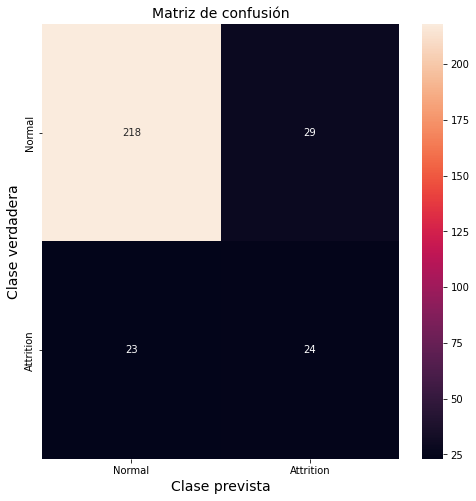

              precision    recall  f1-score     support
0              0.904564  0.882591  0.893443  247.000000
1              0.452830  0.510638  0.480000   47.000000
accuracy       0.823129  0.823129  0.823129    0.823129
macro avg      0.678697  0.696615  0.686721  294.000000
weighted avg   0.832348  0.823129  0.827348  294.000000


In [1359]:
save_fig("Matriz_Confusion_Ensamble")  # extra code
mostrar_resultados(y_test, pred_y)

Se evaluará su rendimiento y se observa una mejora en comparación con el modelo inicial, con un recall de 0.38 para los casos de deserción laboral.

Almaceno el reporte de clafificación para realizar una comparación con otros modelos:

In [1360]:
clsf_report_mod5 = pd.DataFrame(classification_report(y_test, pred_y, output_dict=True)).transpose()
clsf_report_mod5['precision'][2] * 100

82.31292517006803

En cuanto a los resultados obtenidos, se presentan en una tabla ordenada de mejor a peor. 

In [1361]:
df = pd.DataFrame({'algorithm' : ['Regresion Logística', 'Penalización', 'NearMiss Subsampling', 
                                  'Random Oversampling', 'Smote Tomek', 'Ensemble'],
                   'precision' : [round(clsf_report_mod0['precision'][0],2), 
                                  round(clsf_report_mod1['precision'][0],2), 
                                  round(clsf_report_mod2['precision'][0],2), 
                                  round(clsf_report_mod3['precision'][0],2), 
                                  round(clsf_report_mod4['precision'][0],2), 
                                  round(clsf_report_mod5['precision'][0],2)],
                   'recall' : [round(clsf_report_mod0['recall'][1],2), 
                               round(clsf_report_mod1['recall'][1],2), 
                               round(clsf_report_mod2['recall'][1],2), 
                               round(clsf_report_mod3['recall'][1],2), 
                               round(clsf_report_mod4['recall'][1],2), 
                               round(clsf_report_mod5['recall'][1],2)]})

df['overall'] = df.apply(lambda row: (row.precision + row.recall)/2, axis=1)

df = df.sort_values(['overall'], ascending=False)
df

algorithm  precision  recall  overall
1          Penalización       0.93    0.68    0.805
2  NearMiss Subsampling       0.92    0.62    0.770
3   Random Oversampling       0.92    0.60    0.760
5              Ensemble       0.90    0.51    0.705
4           Smote Tomek       0.90    0.49    0.695
0   Regresion Logística       0.89    0.38    0.635

La estrategia con la que se obtiene mejor resultado es la **Penalización** con una precision del 0.93 y un recall del 0.68, lo que indica que es capaz de clasificar correctamente tanto las instancias positivas como las negativas de la clase minoritaria.<br>
El modelo 2 obtuvo una precision parecida sin embargo fué mucho menor el recall con respecto al modelo 1.
Los modelos 3, 4 y 5 mantuvieron una presición del 0.9 sin embargo el recall iba disminuyendo, sin embargo, es importante destacar que todas las técnicas aplicadas logran mejorar el modelo inicial de Regresión Logística, que solo alcanzaba un 0.38 de recall para la clase de Attrition (deserción laboral). Cabe recordar que el conjunto de datos presenta un desbalanceo considerable entre las clases.



##Balanceo

Luego de algunas pruebas con datos balanceados, se decide no aplicar ninguna de las técnicas de balanceo ya que los resultados de predicción no mejoran los resultados obtenidos sin balanceo:

In [1362]:
X_train_balanced = X_train
y_train_balanced = y_train

##Grid search

In [1363]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [1364]:
grid=[i for i in range(-5,7,1)]
param_grid={'C':[2**i for i in grid], 'gamma':[2**(0.5*i) for i in grid]}

In [1365]:
param_grid['C']

[0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]

In [1366]:
param_grid['gamma']

[0.1767766952966369,
 0.25,
 0.3535533905932738,
 0.5,
 0.7071067811865476,
 1.0,
 1.4142135623730951,
 2.0,
 2.8284271247461903,
 4.0,
 5.656854249492381,
 8.0]

In [1367]:
clf=GridSearchCV(SVC(kernel='rbf'),param_grid=param_grid,n_jobs=-1,verbose=2)  #GridSearchCV(modelo,grilla,paralelizar,regularización)

In [1368]:
clf.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32, 64],
                         'gamma': [0.1767766952966369, 0.25, 0.3535533905932738,
                                   0.5, 0.7071067811865476, 1.0,
                                   1.4142135623730951, 2.0, 2.8284271247461903,
                                   4.0, 5.656854249492381, 8.0]},
             verbose=2)

In [1369]:
import pandas as pd

cv_results=pd.DataFrame(clf.cv_results_)

In [1370]:
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0         0.048978      0.010692         0.023969        0.015228  0.03125   
1         0.058560      0.017605         0.030751        0.017932  0.03125   
2         0.106419      0.026491         0.040462        0.018535  0.03125   
3         0.197144      0.029759         0.059467        0.009877  0.03125   
4         0.169933      0.044080         0.053275        0.009006  0.03125   
..             ...           ...              ...             ...      ...   
139       0.261839      0.072993         0.064692        0.024381       64   
140       0.259250      0.068766         0.060862        0.016375       64   
141       0.244027      0.033246         0.067924        0.023506       64   
142       0.271378      0.030638         0.064888        0.017718       64   
143       0.270518      0.044913         0.075496        0.017367       64   

    param_gamma                                       params  \
0      0.176777  {'C': 0.03125, 'gamma': 0.1767766952966369}   
1          0.25                {'C': 0.03125, 'gamma': 0.25}   
2      0.353553  {'C': 0.03125, 'gamma': 0.3535533905932738}   
3           0.5                 {'C': 0.03125, 'gamma': 0.5}   
4      0.707107  {'C': 0.03125, 'gamma': 0.7071067811865476}   
..          ...                                          ...   
139         2.0                      {'C': 64, 'gamma': 2.0}   
140    2.828427       {'C': 64, 'gamma': 2.8284271247461903}   
141         4.0                      {'C': 64, 'gamma': 4.0}   
142    5.656854        {'C': 64, 'gamma': 5.656854249492381}   
143         8.0                      {'C': 64, 'gamma': 8.0}   

     split0_test_score  split1_test_score  split2_test_score  \
0             0.838983           0.838298           0.838298   
1             0.838983           0.838298           0.838298   
2             0.838983           0.838298           0.838298   
3             0.838983           0.838298           0.838298   
4             0.838983           0.838298           0.838298   
..                 ...                ...                ...   
139           0.838983           0.838298           0.838298   
140           0.838983           0.838298           0.838298   
141           0.838983           0.838298           0.838298   
142           0.838983           0.838298           0.838298   
143           0.838983           0.838298           0.838298   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0             0.838298           0.838298         0.838435        0.000274   
1             0.838298           0.838298         0.838435        0.000274   
2             0.838298           0.838298         0.838435        0.000274   
3             0.838298           0.838298         0.838435        0.000274   
4             0.838298           0.838298         0.838435        0.000274   
..                 ...                ...              ...             ...   
139           0.838298           0.838298         0.838435        0.000274   
140           0.838298           0.838298         0.838435        0.000274   
141           0.838298           0.838298         0.838435        0.000274   
142           0.838298           0.838298         0.838435        0.000274   
143           0.838298           0.838298         0.838435        0.000274   

     rank_test_score  
0                 42  
1                 42  
2                 42  
3                 42  
4                 42  
..               ...  
139               42  
140               42  
141               42  
142               42  
143               42  

[144 rows x 15 columns]

In [1371]:
print(len(cv_results))
print(len(param_grid['C']))
print(len(param_grid['gamma']))
total=len(param_grid['C'])*len(param_grid['gamma'])
print(total)

144
12
12
144


In [1372]:
scores=clf.cv_results_['mean_test_score'].reshape(len(param_grid['C']),len(param_grid['gamma']))

<Figure size 432x288 with 0 Axes>

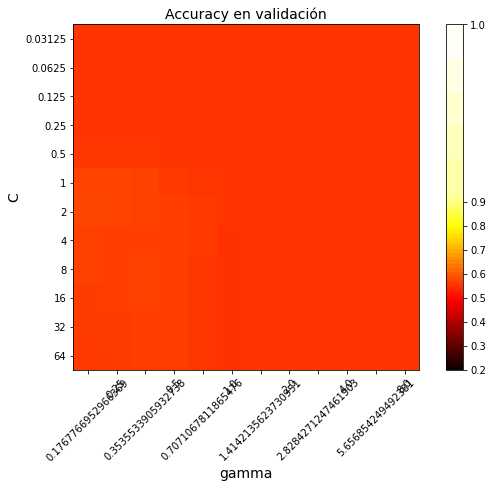

In [1373]:
save_fig("Accuracy en validacion")  # extra code
plt.figure(figsize=(10, 6))  #entre más claro mejor el resultado de la búsqueda de grillas
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92, vmax=1.))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Accuracy en validación')
plt.show()

In [1374]:
clf.best_params_

{'C': 2, 'gamma': 0.1767766952966369}

In [1375]:
clf.best_score_

0.8767039307609087

In [1376]:
cv_bestresults=cv_results[['param_C','param_gamma','mean_test_score']]

In [1377]:
cv_bestresults.head()

param_C param_gamma  mean_test_score
0  0.03125    0.176777         0.838435
1  0.03125        0.25         0.838435
2  0.03125    0.353553         0.838435
3  0.03125         0.5         0.838435
4  0.03125    0.707107         0.838435

In [1378]:
cv_bestresults.sort_values(by='mean_test_score', ascending=False) #en orden top de los resultados

param_C param_gamma  mean_test_score
72        2    0.176777         0.876704
60        1    0.176777         0.874998
73        2        0.25         0.874151
61        1        0.25         0.872445
74        2    0.353553         0.869044
..      ...         ...              ...
101       8         1.0         0.835041
89        4         1.0         0.835041
137      64         1.0         0.835041
113      16         1.0         0.835041
125      32         1.0         0.835041

[144 rows x 3 columns]

In [1379]:
clf.best_score_

0.8767039307609087

In [1380]:
clf.best_params_

{'C': 2, 'gamma': 0.1767766952966369}

In [1381]:
clf.score(X_test,y_test)

0.8741496598639455

In [1382]:
grid_search_accuracy = clf.score(X_test,y_test) * 100
grid_search_accuracy

87.41496598639455

#Otros modelos

##RandomForest

In [1383]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform  #para el %
from scipy.stats import randint  #para la lista de árboles
from time import time

In [1384]:
clf = RandomForestClassifier()

param_dist = {"n_estimators": randint(4, 800),
              "max_features": uniform()}

In [1385]:
n_iter_search = 20 #número de elementos donde va realizar la búsqueda aleatoria (configuraciones de escogencias aleatorias)
#búsqueda aleatoria
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                                   n_iter=n_iter_search, cv=5, #cv -> pliegues
                                   n_jobs=-1, verbose=2)

In [1386]:
start = time()
random_search.fit(X_train_balanced, y_train_balanced)
print("RandomizedSearchCV tomó {} segundos usando {} configuraciones".format(time() - start,
                                                                               n_iter_search))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomizedSearchCV tomó 178.27767086029053 segundos usando 20 configuraciones


In [1387]:
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results = cv_results[['param_n_estimators','param_max_features','mean_test_score']]
cv_results.sort_values(by='mean_test_score',ascending=False).head()

param_n_estimators param_max_features  mean_test_score
2                  71           0.167171         0.857144
12                382           0.777197         0.857144
1                 669           0.699753         0.857144
8                 765           0.897552         0.856293
16                648           0.664217         0.856293

In [1388]:
random_search.best_params_

{'max_features': 0.699752894357787, 'n_estimators': 669}

In [1389]:
random_search.best_score_

0.8571438874864767

In [1390]:
random_search.score(X_test, y_test)

0.8707482993197279

In [1391]:
randomforest_accuracy = random_search.score(X_test, y_test) * 100
randomforest_accuracy

87.07482993197279

In [1392]:
clf = RandomForestClassifier(n_estimators=338, max_features=0.09143233077887347)

clf.fit(X_train_balanced, y_train_balanced);

In [1393]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Importancia de características:")

for f in range(X_train.shape[1]):
    print("Característica %s (%f)" % (X_train.columns[indices[f]], importances[indices[f]]))

Importancia de características:
Característica MonthlyIncome (0.072957)
Característica Age (0.068685)
Característica TotalWorkingYears (0.061569)
Característica DistanceFromHome (0.054235)
Característica YearsAtCompany (0.048520)
Característica OverTime (0.044022)
Característica NumCompaniesWorked (0.041641)
Característica EnvironmentSatisfaction (0.038261)
Característica YearsWithCurrManager (0.038037)
Característica YearsInCurrentRole (0.036590)
Característica TrainingTimesLastYear (0.034738)
Característica JobSatisfaction (0.034327)
Característica JobInvolvement (0.033643)
Característica RelationshipSatisfaction (0.032919)
Característica YearsSinceLastPromotion (0.031877)
Característica WorkLifeBalance (0.031702)
Característica StockOptionLevel (0.031469)
Característica Education (0.028834)
Característica JobLevel (0.028685)
Característica BusinessTravel (0.023500)
Característica MaritalStatus_Single (0.019611)
Característica JobRole_Laboratory Technician (0.015090)
Característica G

##K-Means

In [1394]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [1395]:
cols = X.columns
ms = MinMaxScaler()
X_normalized = ms.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=[cols])

Método del codo elbow para encontrar el número optimo de grupos

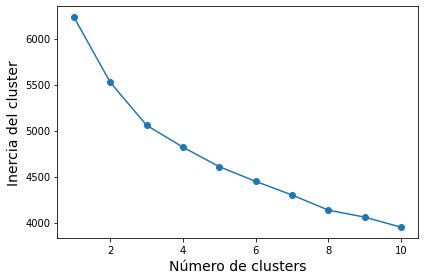

In [1396]:
save_fig("Inercia_cluster")  # extra code
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                tol=1e-04,
                random_state=40)
    km.fit(X_normalized)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia del cluster')
plt.tight_layout()
#plt.savefig('./figures/elbow.png', dpi=300)
plt.show()

In [1397]:
print('Inercia del cluster: %.2f' % km.inertia_)

Inercia del cluster: 3948.82


De la gráfica anterior se puede apreciar que para k=2 hay una buena opción de agrupamiento de datos

En el siguiente gráfico generamos los coeficientes de silueta para un agrupamiento de k-means con k=2

In [1398]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=40)
y_km = km.fit_predict(X_normalized)

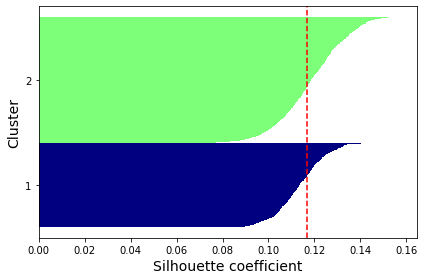

In [1399]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_normalized, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
save_fig("Coeficiente_Silueta")  # extra code
plt.show()

In [1400]:
k_means = KMeans(n_clusters=2, random_state=0)
y_k_means = k_means.fit_predict(X_normalized)
labels = k_means.labels_
# comprobar cuántas de las muestras estan correctamente etiquetadas
correct_labels = sum(y == labels)
k_means_accuracy = (correct_labels *100)/ float(y.size)
print("Resultado: %d de %d muestras se etiquetaron correctamente." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f} %'.format(k_means_accuracy))

Resultado: 651 de 1470 muestras se etiquetaron correctamente.
Accuracy score: 44.29 %


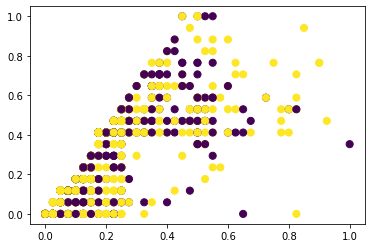

In [1401]:
save_fig("KMeansScatter")  # extra code
plt.scatter(X_normalized['YearsAtCompany'],X_normalized['YearsWithCurrManager'], c=labels, s=50, cmap='viridis');

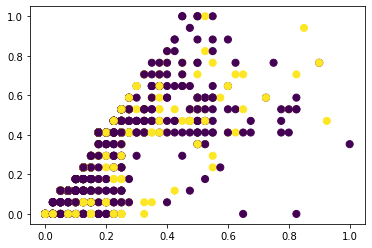

In [1402]:
from sklearn.cluster import SpectralClustering #libreria basada en grafos

model = []
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', 
                           assign_labels='kmeans')
labels = model.fit_predict(X)
save_fig("KMeansScatterSpectralClustering")  # extra code
plt.scatter(X_normalized['YearsAtCompany'],X_normalized['YearsWithCurrManager'], c=labels, s=50, cmap='viridis');

In [1403]:
# comprobar cuántas de las muestras estan correctamente etiquetadas
correct_labels = sum(y == labels)
spectralclustering_accuracy = (correct_labels *100)/ float(y.size)
print("Resultado: %d de %d muestras se etiquetaron correctamente." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f} %'.format(spectralclustering_accuracy))

Resultado: 964 de 1470 muestras se etiquetaron correctamente.
Accuracy score: 65.58 %


Se obseva una mejora al utlizar SpectralClustering pasando del 44.29% del KMeans al 65.58%, sin embargo no es una medida adecuada de clasificicón del conjunto de datos.

##Reducción de dimensionalidad

In [1404]:
# Importamos el paquete PCA de scikit-learn
from sklearn.decomposition import PCA

# Creamos una instancia de PCA con dos componentes
pca = PCA(n_components=2)
# Ajustamos la instancia de PCA con los datos X
pca.fit(X)

# Imprimimos los componentes calculados por scikit-learn
print("sklearn PCA components")
print(pca.components_)

sklearn PCA components
[[ 1.68093266e-02  3.34043818e-02  4.93026683e-03  1.81157431e-02
  -1.13842958e-02 -1.01839645e-02  8.00168301e-02 -8.04815018e-03
   5.76092778e-02 -6.59115959e-04  2.97566554e-02 -7.19792126e-03
  -1.95073559e-02  2.55009399e-02  4.95260429e-03  2.06772826e-02
   2.22246227e-02  2.82707446e-02  2.47367525e-02  2.34158524e-02
   3.41716654e-01 -3.41716654e-01 -5.50628105e-01  5.33284540e-01
   9.11136699e-03 -9.72389265e-02  2.35815358e-01 -1.32286009e-01
  -4.09960018e-04 -7.07036017e-02  1.16676779e-02 -2.24452016e-01
   4.63269224e-02 -6.39773557e-02 -3.10266600e-02  1.03370450e-01
  -6.38936505e-02  3.73944635e-02  2.64991870e-02]
 [ 1.41736575e-02  7.84398034e-02 -2.66029099e-03 -2.78721850e-04
   8.87164741e-03 -1.46870276e-03 -7.45439465e-03 -2.22473206e-02
  -1.49553094e-03  2.33422632e-02  3.72608185e-02 -8.57373009e-03
  -1.63163933e-02  1.54285299e-02  1.13812950e-02 -1.05661265e-02
   3.14507469e-03  5.53584280e-03  4.48873929e-03  6.12734097e-03
  

In [1405]:
X.shape

(1470, 39)

In [1406]:
%timeit pca.fit(X)

17.7 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


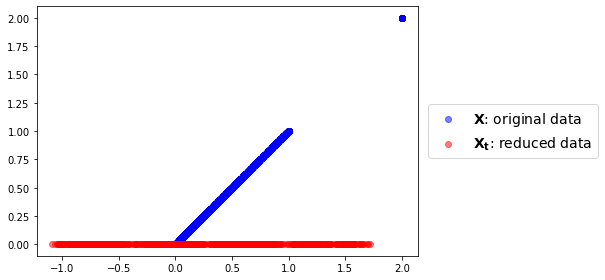

In [1407]:
# Creamos un objeto PCA con 1 componente para reducir la dimensionalidad de los datos de X a 1D
pca = PCA(n_components=1)

# Ajustamos el modelo PCA a los datos X
pca.fit(X)

# Transformamos los datos X al espacio reducido con PCA
Xt = pca.transform(X)[:,0]

# Graficamos los datos originales X en azul y los datos transformados Xt en rojo en el eje horizontal
# El eje vertical está fijado en 0 para visualizar mejor la reducción de dimensionalidad
plt.scatter(X, X, color="blue", alpha=.5, label="$\mathbf{X}$: original data")
plt.scatter(Xt, [0]*len(Xt), color="red", alpha=.5, label="$\mathbf{X_t}$: reduced data")

# Establecemos el mismo rango en ambos ejes para una mejor visualización y agregamos una leyenda
plt.axis("equal");
save_fig("PCA")  # extra code
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

Clasificador Naive Bayes y calcula el desempeño de la clasificación en los datos originales y los datos transformados por PCA

In [1408]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

pca = PCA(n_components=29)
Xp = pca.fit_transform(X)

print(np.mean(cross_val_score(GaussianNB(), X, y, cv=5)))
print(np.mean(cross_val_score(GaussianNB(), Xp, y, cv=5)))

0.6557823129251702
0.8428571428571429


In [1409]:
pca_accuracy = np.mean(cross_val_score(GaussianNB(), Xp, y, cv=5)) * 100

###Singular Value Decomposition (SVD)

In [1410]:
U, s, V = np.linalg.svd(X)

In [1411]:
U.shape, s.shape, V.shape

((1470, 1470), (39,), (39, 39))

Reconstruimos la matriz diagonal s

In [1412]:
# Convertir el vector de valores singulares en una matriz diagonal
s = np.diag(s)
# Añadir filas de ceros a la matriz de valores singulares para que tenga la misma forma que U
s = np.vstack([s, np.zeros((U.shape[0]-s.shape[0], s.shape[1]))])

Verificamos las propiedades SVD

In [1413]:
print("verificando si U es unitaria: ", np.allclose(U.dot(U.T), np.eye(U.shape[0])))
print("verificando si las filas de U son unitarias: ", np.allclose(np.linalg.norm(U, axis=1), np.ones(U.shape[0])))
print("verificando si las columnas de U son unitarias: ", np.allclose(np.linalg.norm(U, axis=0), np.ones(U.shape[1])))
print("verificando si V es unitaria: ", np.allclose(V.T.dot(V), np.eye(V.shape[0])))
print("verificando si las filas de V son unitarias: ", np.allclose(np.linalg.norm(V, axis=1), np.ones(V.shape[0])))
print("verificando si las columnas de V son unitarias: ", np.allclose(np.linalg.norm(V, axis=0), np.ones(V.shape[1])))
print("verificando la reconstrucción de X: ", np.allclose(U.dot(s).dot(V), X))

verificando si U es unitaria:  True
verificando si las filas de U son unitarias:  True
verificando si las columnas de U son unitarias:  True
verificando si V es unitaria:  True
verificando si las filas de V son unitarias:  True
verificando si las columnas de V son unitarias:  True
verificando la reconstrucción de X:  True


Text(0, 0.5, 'component value')

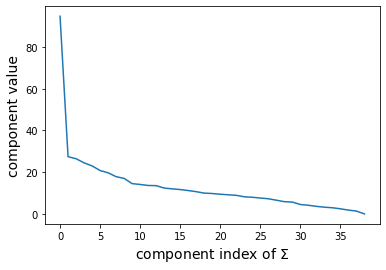

In [1414]:
save_fig("SVD")  # extra code
plt.plot(np.diagonal(s))
plt.xlabel("component index of $\Sigma$");
plt.ylabel("component value")

In [1415]:
Xm = X-np.mean(X, axis=0)
U,s,V = np.linalg.svd(Xm)
pca = PCA(n_components=29)
pca.fit(Xm);

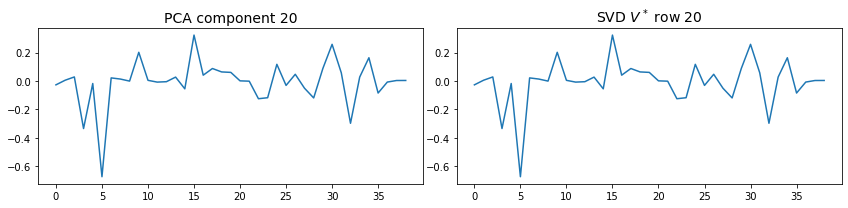

In [1416]:
i = np.random.randint(pca.n_components)
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(pca.components_[i])
plt.title("PCA component %d"%i)
plt.subplot(122)
plt.title("SVD $V^*$ row %d"%i)
save_fig("PCA_SVD")  # extra code
plt.plot(V[i])

In [1417]:
n_components = np.argwhere(np.cumsum(s)/np.sum(s)>.4)[0][0]
print("Keeping %d components"%n_components)

Keeping 7 components


Al probar las reducciones de dimensionalidad, la que mejora un poco el accuracy es la PCA pasando del 0.85 con clasificador Naive Bayes al 0.84 con PCA.<br>
Sin embargo, SVD me reduce a 7 componentes.

##Técnicas de Deep Learning

###Redes Neuronales NNs

In [1482]:
tf.keras.backend.clear_session() 

In [1483]:
tf.random.set_seed(40)

In [1484]:
#Crear modelo secuencial de keras
model_nn = []
model_nn = tf.keras.Sequential()

In [1485]:
model_nn.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu')),
model_nn.add(Dropout(0.4)),
model_nn.add(Dense(16, activation='relu')),
model_nn.add(Dropout(0.2)),
model_nn.add(Dense(4, activation='relu')),
model_nn.add(Dropout(0.2)),
model_nn.add(Dense(2, activation='relu')),
model_nn.add(Dropout(0.2)),
model_nn.add(Dense(1, activation='sigmoid'))

In [1434]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2560      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1

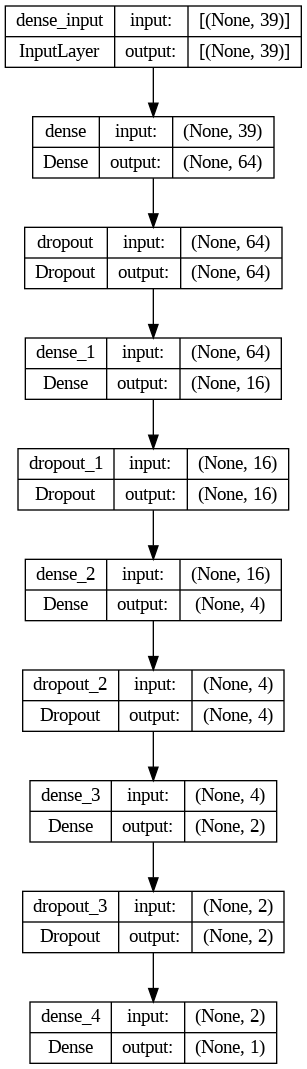

In [1435]:
plot_model(model_nn, to_file='model_nn.png',show_shapes=True)

In [1486]:
#Compilar el modelo, especificando el optimizador, la función de pérdida y la métrica
model_nn.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=[('accuracy')])

In [1487]:
# Entrenar el modelo con los datos de entrenamiento durante 5 épocas
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=30, verbose=1,restore_best_weights=True)
history_batch = model_nn.fit(X_train_balanced, y_train_balanced, batch_size=8, epochs=200,validation_split = 0.15, callbacks = [earlystopper],verbose = 1)

Epoch 1/200
125/125 [==============================] - 3s 8ms/step - loss: 0.7009 - accuracy: 0.7037 - val_loss: 0.6557 - val_accuracy: 0.8588
Epoch 2/200
125/125 [==============================] - 1s 5ms/step - loss: 0.6435 - accuracy: 0.8308 - val_loss: 0.6224 - val_accuracy: 0.8588
Epoch 3/200
125/125 [==============================] - 1s 5ms/step - loss: 0.6139 - accuracy: 0.8338 - val_loss: 0.5922 - val_accuracy: 0.8588
Epoch 4/200
125/125 [==============================] - 0s 4ms/step - loss: 0.5878 - accuracy: 0.8348 - val_loss: 0.5664 - val_accuracy: 0.8588
Epoch 5/200
125/125 [==============================] - 0s 4ms/step - loss: 0.5662 - accuracy: 0.8348 - val_loss: 0.5439 - val_accuracy: 0.8588
Epoch 6/200
125/125 [==============================] - 0s 3ms/step - loss: 0.5473 - accuracy: 0.8348 - val_loss: 0.5245 - val_accuracy: 0.8588
Epoch 7/200
125/125 [==============================] - 0s 3ms/step - loss: 0.5312 - accuracy: 0.8348 - val_loss: 0.5078 - val_accuracy: 0.8588

<Figure size 432x288 with 0 Axes>

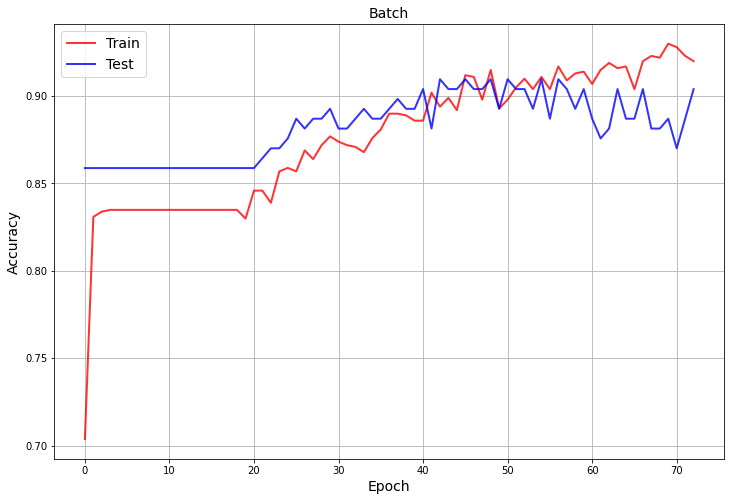

In [1488]:
save_fig("Batch_NN")  # extra code
plt.figure(figsize=(12,8))
plt.plot(history_batch.history['accuracy'], label='Train', c='r', linewidth=2, alpha=0.8)
plt.plot(history_batch.history['val_accuracy'], label='Test', c='b', linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Batch')
plt.legend()
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

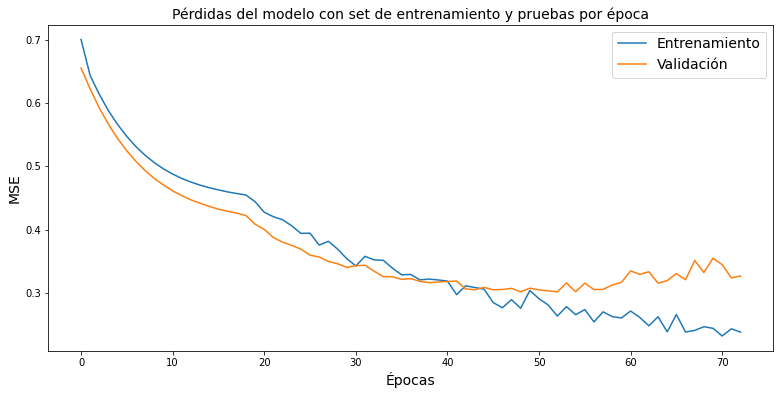

In [1489]:
import matplotlib.pyplot as plt
%matplotlib inline

save_fig("Perdidas_entrenamiento_pruebas_por_epoca_NN")  # extra code
plt.figure(figsize=(13,6))
plt.plot(history_batch.history['loss'])
plt.plot(history_batch.history['val_loss'])
plt.title("Pérdidas del modelo con set de entrenamiento y pruebas por época")
plt.ylabel('MSE')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

In [1490]:
# Evaluar el modelo en los datos de prueba y obtener la pérdida y precisión
test_loss, test_acc = model_nn.evaluate(X_test, y_test);
# Imprimir la precisión en los datos de prueba
print('\nPrecisión en los datos de prueba: ', test_acc)
redes_neuronales_accuracy = test_acc * 100

10/10 [==============================] - 0s 2ms/step - loss: 0.3364 - accuracy: 0.8776

Precisión en los datos de prueba:  0.8775510191917419


###Convolucional Neural Network CNN

Se transforma la dimensión de los datos de entrada

In [1532]:
tf.keras.backend.clear_session() 

In [1533]:
tf.random.set_seed(40)

In [1523]:
X_train_res = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)

In [1495]:
X_train_res.shape

(1176, 39, 1)

In [1496]:
y_train_res = pd.concat([y_train], axis=1)
y_train_res = y_train_res.values.reshape(y_train_res.shape[0], y_train_res.shape[1], 1)

In [1497]:
y_train_res.shape

(1176, 1, 1)

In [1498]:
X_test_res = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

In [1499]:
X_test_res.shape

(294, 39, 1)

In [1500]:
#y_test_res = abs(-1+y_test)
y_test_res = pd.concat([y_test], axis=1)
y_test_res = y_test_res.values.reshape(y_test_res.shape[0], y_test_res.shape[1], 1)

In [1501]:
y_test_res.shape

(294, 1, 1)

Se crea el modelo con las capas convulocionales y las capas de clasificación:
* Para este set de datos se decidió trabajar con CNN de 1 dimensión.

In [1641]:
def make_model(X_train_res):
    model = Sequential()
    model.add(Convolution1D(filters=32, kernel_size=3, activation='relu', strides=1, padding='same', input_shape=X_train_res.shape[1:3]))
    model.add(BatchNormalization())

    model.add(Convolution1D(32, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Convolution1D(64, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(32, input_shape=(X_train_res.shape[1],), activation='relu')),
    model.add(Dropout(0.5)),
    model.add(Dense(16, activation='relu')),
    model.add(Dropout(0.2)),
    model.add(Dense(8, activation='relu')),
    model.add(Dropout(0.2)),
    model.add(Dense(2, activation='relu')),
    model.add(Dropout(0.2)),
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [1642]:
tf.keras.backend.clear_session() 

In [1643]:
tf.random.set_seed(40)

In [1644]:
model_cnn = []
model_cnn = make_model(X_train_res)

In [1645]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 32)            128       
                                                                 
 batch_normalization (BatchN  (None, 39, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 32)            3104      
                                                                 
 batch_normalization_1 (Batc  (None, 37, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 37, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 64)            6

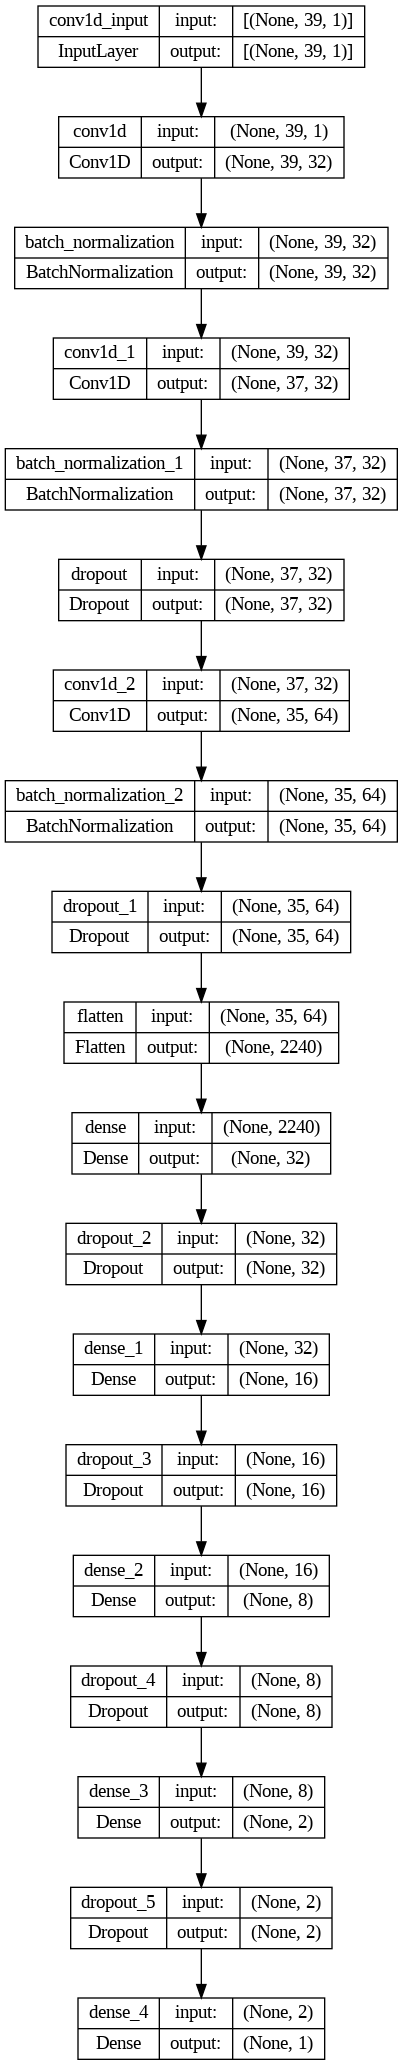

In [1646]:
plot_model(model_cnn, to_file='model_cnn.png',show_shapes=True)

In [1647]:
#Compilar el modelo, especificando el optimizador, la función de pérdida y la métrica
model_cnn.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=[('accuracy')])

In [1648]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=30, verbose=1,restore_best_weights=True)
history_batch = model_cnn.fit(X_train_balanced, y_train_balanced, batch_size=16, epochs=200,validation_split = 0.15, callbacks = [earlystopper],verbose = 1)

Epoch 1/200
63/63 [==============================] - 8s 17ms/step - loss: 0.6331 - accuracy: 0.8068 - val_loss: 0.6062 - val_accuracy: 0.8588
Epoch 2/200
63/63 [==============================] - 1s 12ms/step - loss: 0.5388 - accuracy: 0.8158 - val_loss: 0.6216 - val_accuracy: 0.8588
Epoch 3/200
63/63 [==============================] - 1s 12ms/step - loss: 0.5180 - accuracy: 0.8308 - val_loss: 0.5067 - val_accuracy: 0.8588
Epoch 4/200
63/63 [==============================] - 1s 11ms/step - loss: 0.4704 - accuracy: 0.8338 - val_loss: 0.4215 - val_accuracy: 0.8588
Epoch 5/200
63/63 [==============================] - 1s 12ms/step - loss: 0.4762 - accuracy: 0.8318 - val_loss: 0.4140 - val_accuracy: 0.8588
Epoch 6/200
63/63 [==============================] - 1s 12ms/step - loss: 0.4597 - accuracy: 0.8368 - val_loss: 0.3768 - val_accuracy: 0.8588
Epoch 7/200
63/63 [==============================] - 1s 12ms/step - loss: 0.4581 - accuracy: 0.8358 - val_loss: 0.3682 - val_accuracy: 0.8588
Epoch 

<Figure size 432x288 with 0 Axes>

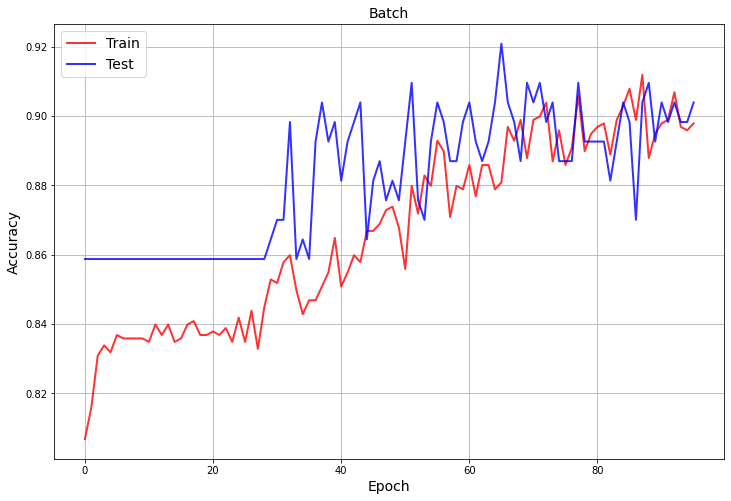

In [1650]:
save_fig("Batch_CNN")  # extra code
plt.figure(figsize=(12,8))
plt.plot(history_batch.history['accuracy'], label='Train', c='r', linewidth=2, alpha=0.8)
plt.plot(history_batch.history['val_accuracy'], label='Test', c='b', linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Batch')
plt.legend()
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

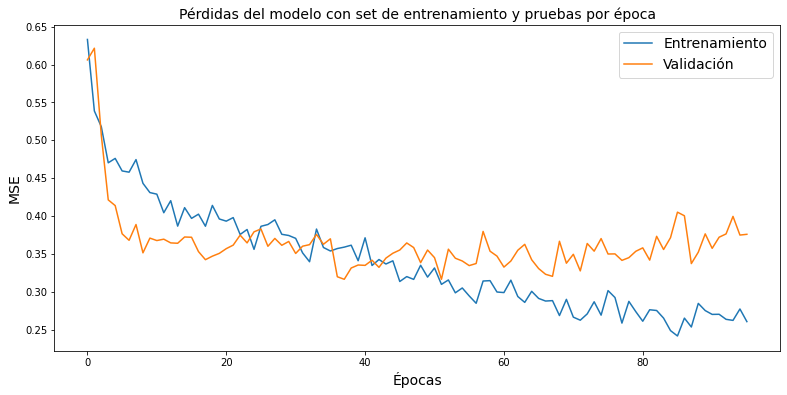

In [1651]:
import matplotlib.pyplot as plt
%matplotlib inline

save_fig("Perdidas_entrenamiento_pruebas_por_epoca_CNN")  # extra code
plt.figure(figsize=(13,6))
plt.plot(history_batch.history['loss'])
plt.plot(history_batch.history['val_loss'])
plt.title("Pérdidas del modelo con set de entrenamiento y pruebas por época")
plt.ylabel('MSE')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

In [1649]:
# Evaluar el modelo en los datos de prueba y obtener la pérdida y precisión
test_loss, test_acc = model_cnn.evaluate(X_test_res, y_test_res);
# Imprimir la precisión en los datos de prueba
print('\nPrecisión en los datos de prueba: ', test_acc)
cnn_accuracy = test_acc * 100

10/10 [==============================] - 0s 4ms/step - loss: 0.4004 - accuracy: 0.8810

Precisión en los datos de prueba:  0.8809523582458496


#Resultados

In [1652]:
df = pd.DataFrame({'algorithm' : ['Regresion Logística','Grid Seach', 'RandomForest', 'K-Means', 
                                  'SpectralClustering', 'PCA', 'Redes Neuronales', 'CNN'],
                   'accuracy' : [regresion_logistica_accuracy,
                                  grid_search_accuracy, 
                                  randomforest_accuracy, 
                                  k_means_accuracy, 
                                  spectralclustering_accuracy, 
                                  pca_accuracy, 
                                  redes_neuronales_accuracy,
                                  cnn_accuracy]})

df = df.sort_values(['accuracy'], ascending=False)
df

algorithm   accuracy
7                  CNN  88.095236
0  Regresion Logística  87.755102
6     Redes Neuronales  87.755102
1           Grid Seach  87.414966
2         RandomForest  87.074830
5                  PCA  84.285714
4   SpectralClustering  65.578231
3              K-Means  44.285714